# Selection 1S1 and 1S2 -> Selection in ZRMS vs DT band

In [1]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

from parser_fun import merge_hdfs_multi
from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf

import analysis_functions as af
import stats

#Can be removed later
import importlib
importlib.reload(af)
importlib.reload(stats)
#

<module 'stats' from '/Users/samuele/Documents/Postdoc/NEXT/ASpirit/src/stats.py'>

In [2]:
run_number = 15502
folderdata = [f"/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/{run_number}/"]
df = merge_hdfs_multi(folderdata)

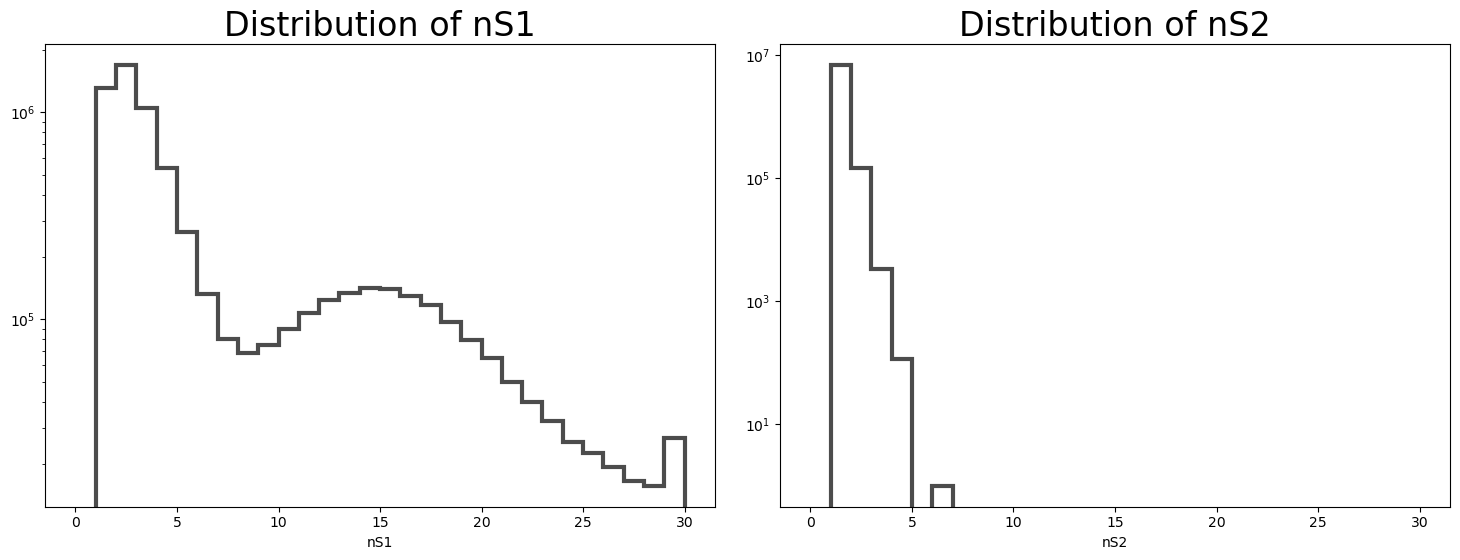

In [3]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
auto_plot_style()

# Plot histogram of df_sel['s1w']
axes[0].hist(df[df['s2_peak']==0]['nS1'], bins=30, range=[0,30], histtype='step', color = color_sequence[0], alpha=0.7)
axes[0].set_xlabel('nS1')
axes[0].set_title('Distribution of nS1')
axes[0].set_yscale('log')

# Plot histogram of df_sel['s1e']
axes[1].hist(df[df['s2_peak']==0]['nS2'], bins=30, range = [0,30], histtype='step',color = color_sequence[0], alpha=0.7)
axes[1].set_xlabel('nS2')
axes[1].set_yscale('log')
axes[1].set_title('Distribution of nS2')

# Adjust layout for better spacing
plt.tight_layout()

In [4]:
df_s1s2 = df[(df['nS1']==1) & (df['nS2']==1)]

print(f"NEvent filtered road : {len(np.unique(df_s1s2['event']))}")
print(f"eff:{(len(np.unique(df_s1s2['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 1301696
eff:45.79%


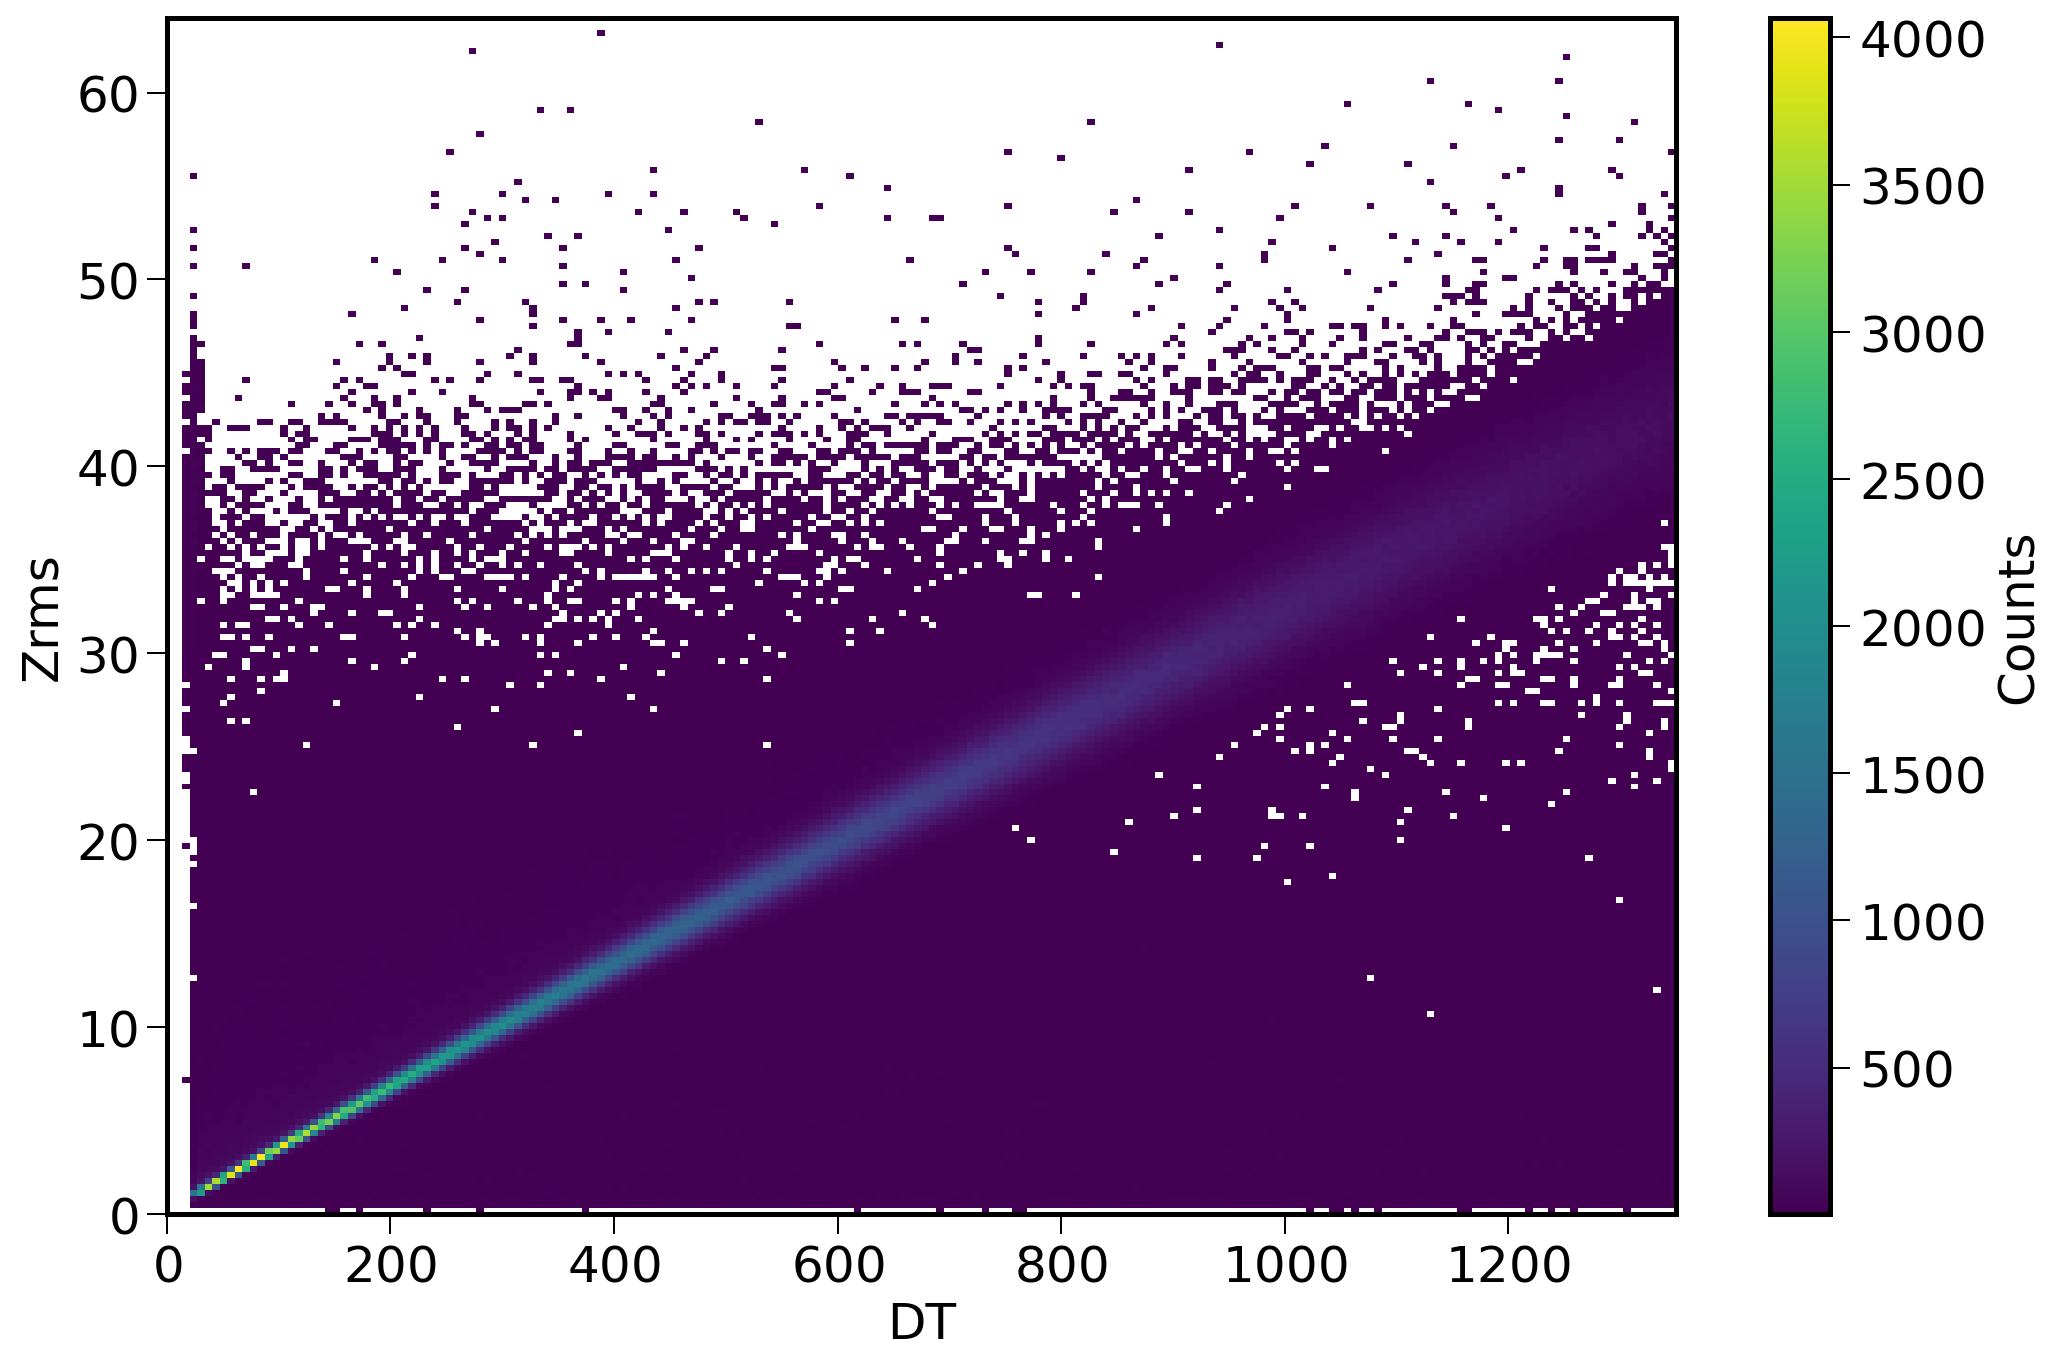

In [5]:
# Compute the 2D histogram data without plotting
counts, xedges, yedges = np.histogram2d(df_s1s2['DT'], np.square(df_s1s2['Zrms']), bins=200, range = ([0,1350],[0,64]))

# Mask bins with counts ≤ 1
counts[counts <= 1] = np.nan  # Convert low-count bins to NaN (displayed as white)

# Create the 2D histogram plot with masked data
plt.figure(figsize=(12, 8),dpi=180)

plt.pcolormesh(xedges, yedges, counts.T, cmap='viridis')
# Add labels and title
plt.xlabel('DT')
plt.ylabel('Zrms')

# Add colorbar to indicate counts
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()


### Diffusion band selection

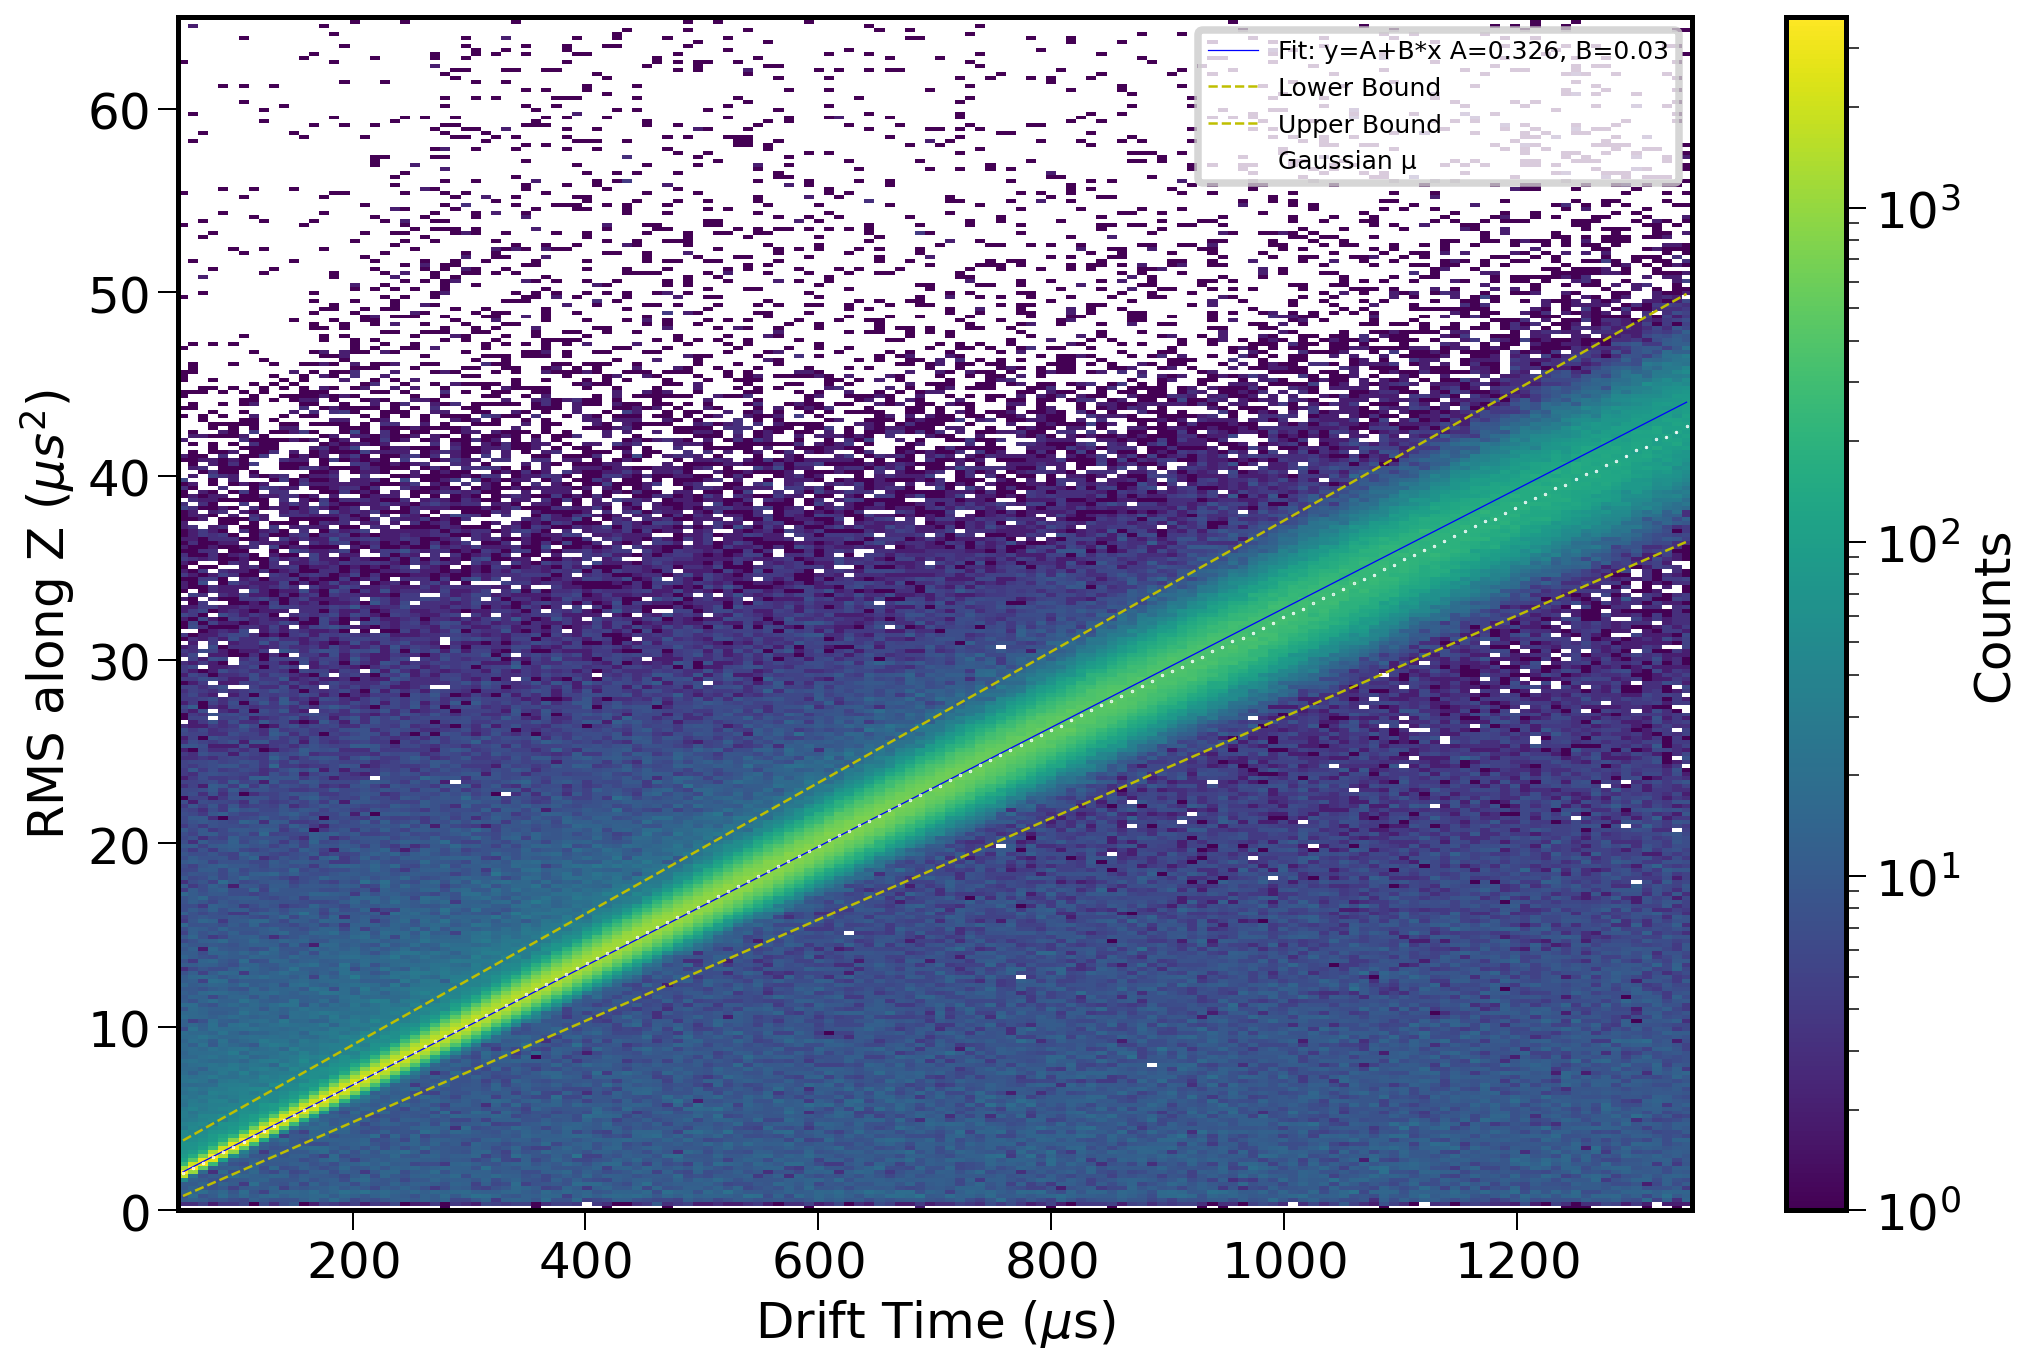

In [6]:
def line_function(x, A, B):
    return A + B*x

counts, xedges, yedges = np.histogram2d(
    df_s1s2[df_s1s2['DT']>50]['DT'],
    np.square(df_s1s2[df_s1s2['DT']>50]['Zrms']),
    bins=(150, 300), range=([50, 1350], [0, 65])
)

dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts, xedges, yedges)

popt_sqrt, pcov_sqrt = curve_fit(line_function, dt_centers, mean_vals, sigma=mean_errs, p0=[1,1/10])

plt.figure(figsize=(12, 8), dpi=180)

# Plot 2D histogram
plt.imshow(
    counts.T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    origin='lower',
    cmap='viridis',
    norm = LogNorm()
)

# Overlay mean values and fit
plt.errorbar(dt_centers, mean_vals, yerr=mean_errs, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')
xfit = np.linspace(min(dt_centers), max(dt_centers), 500)

plt.plot(xfit, line_function(xfit, *popt_sqrt), 'b-', linewidth=.5, label=f'Fit: y=A+B*x A={popt_sqrt[0]:.3f}, B={popt_sqrt[1]:.2f}')

y_center = line_function(xfit, *popt_sqrt)
lower_bound = y_center - 1 - 0.15 * y_center
upper_bound = y_center + 1.5 + 0.1 * y_center

plt.plot(xfit, lower_bound, 'y--', linewidth=1., label='Lower Bound')
plt.plot(xfit, upper_bound, 'y--', linewidth=1., label='Upper Bound')

# Labels and aesthetics
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('RMS along Z ($\mu s^2$)')
plt.colorbar(label='Counts')
plt.grid(False)
plt.legend(fontsize=10)
plt.tight_layout()

In [7]:
df_sel_diff = df_s1s2[ (np.square(df_s1s2['Zrms']) > line_function(df_s1s2['DT'],*popt_sqrt)-1-0.15*line_function(df_s1s2['DT'],*popt_sqrt) ) 
                    & (np.square(df_s1s2['Zrms']) < line_function(df_s1s2['DT'],*popt_sqrt)+1.5+0.1*line_function(df_s1s2['DT'],*popt_sqrt) )  ]

print(f"NEvent filtered road : {len(np.unique(df_sel_diff['event']))}")
print(f"eff:{(len(np.unique(df_sel_diff['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 1113595
eff:39.17%


### 1S1 & 1S2 left selection

In [8]:
df_single_s1_peak=df_sel_diff

print(f"NEvent filtered road : {len(np.unique(df_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_single_s1_peak['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 1113595
eff:39.17%


### Geometric Selection

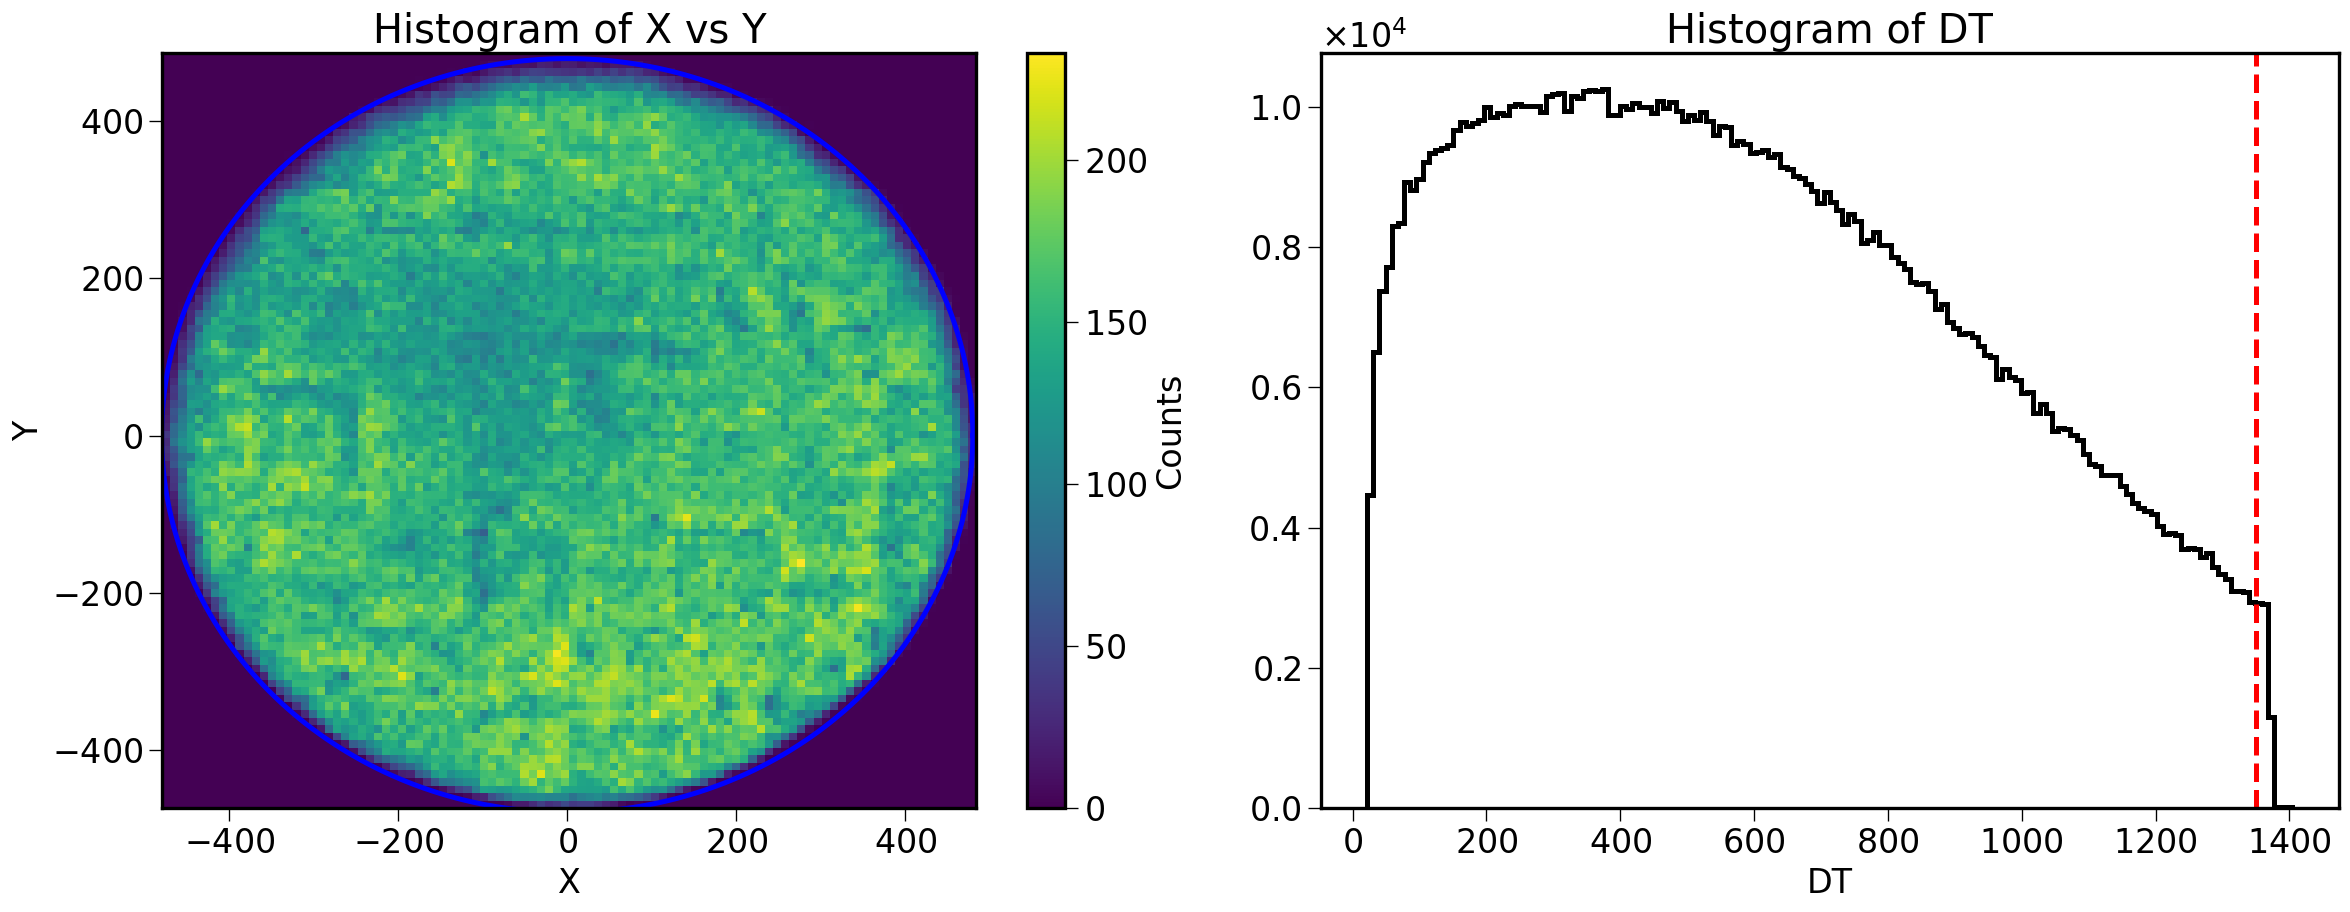

In [9]:
#GeoSel
rad = 480
z = 1350

# Create a figure with two subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Plot histogram of X vs Y
axes[0].hist2d(df_single_s1_peak['X'], df_single_s1_peak['Y'], bins=100, cmap='viridis')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('Histogram of X vs Y')
plt.colorbar(axes[0].collections[0], ax=axes[0], label='Counts')

# Generate points for the circumference
theta = np.linspace(0, 2 * np.pi, 300)
x_circle = 0 + rad * np.cos(theta)
y_circle = 0 + rad * np.sin(theta)
# Plot the circumference
axes[0].plot(x_circle, y_circle, color='blue')

# Plot histogram of X vs DT
axes[1].hist(df_single_s1_peak['DT'], bins=150,histtype='step')
axes[1].set_xlabel('DT')
axes[1].set_title('Histogram of DT')
#axes[1].set_ylim([0,4000])
# Plot the vertical line at x = 1000
axes[1].axvline(x=z, color='red', linestyle='--', label='Vertical Line (x=1000)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [10]:
df_single_s1_peak_geo = df_single_s1_peak[ (df_single_s1_peak['DT']<1350) & (np.sqrt(df_single_s1_peak['X']**2 + df_single_s1_peak['Y']**2)<480 )   ]

print(f"NEvent filtered road : {len(np.unique(df_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_single_s1_peak_geo['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 1113595
eff:38.92%


### Look at the data 

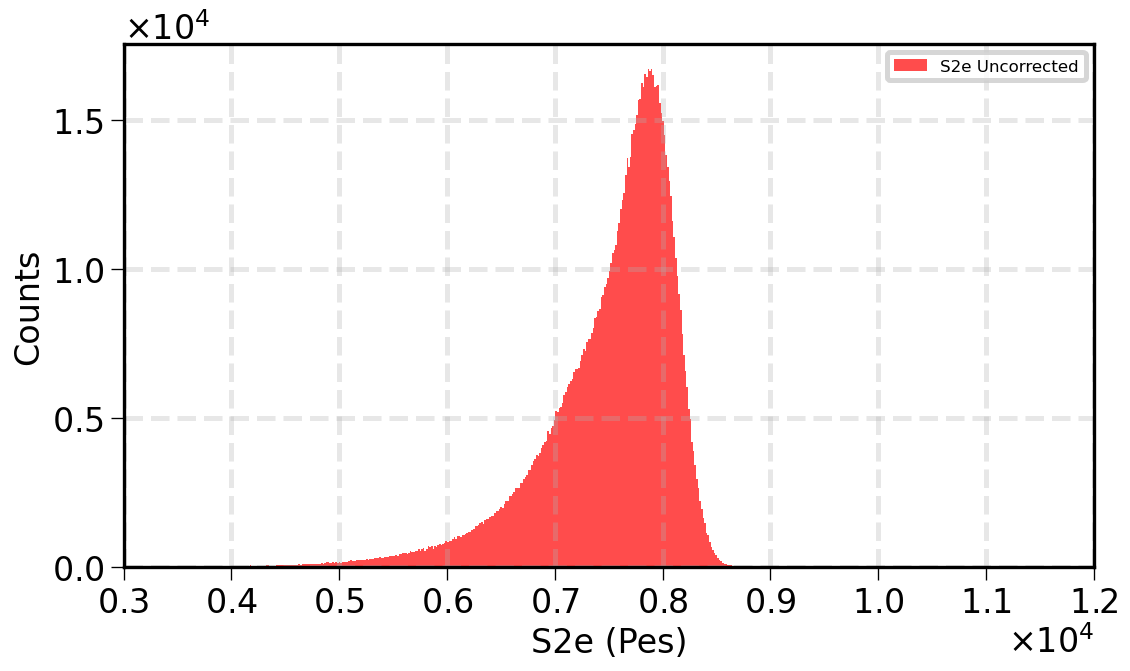

In [11]:
# Plot the histogram of S2e
plt.figure(figsize=(10, 6),dpi=120)
counts, bins, patches = plt.hist(df_single_s1_peak_geo['S2e'], bins=800, range=[0, 12000], 
                                color='red', alpha=0.7, label='S2e Uncorrected')

plt.xlabel('S2e (Pes)')
plt.ylabel('Counts')
plt.legend()
plt.xlim([3000,12000])

# Show the plot
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=10)
plt.show()

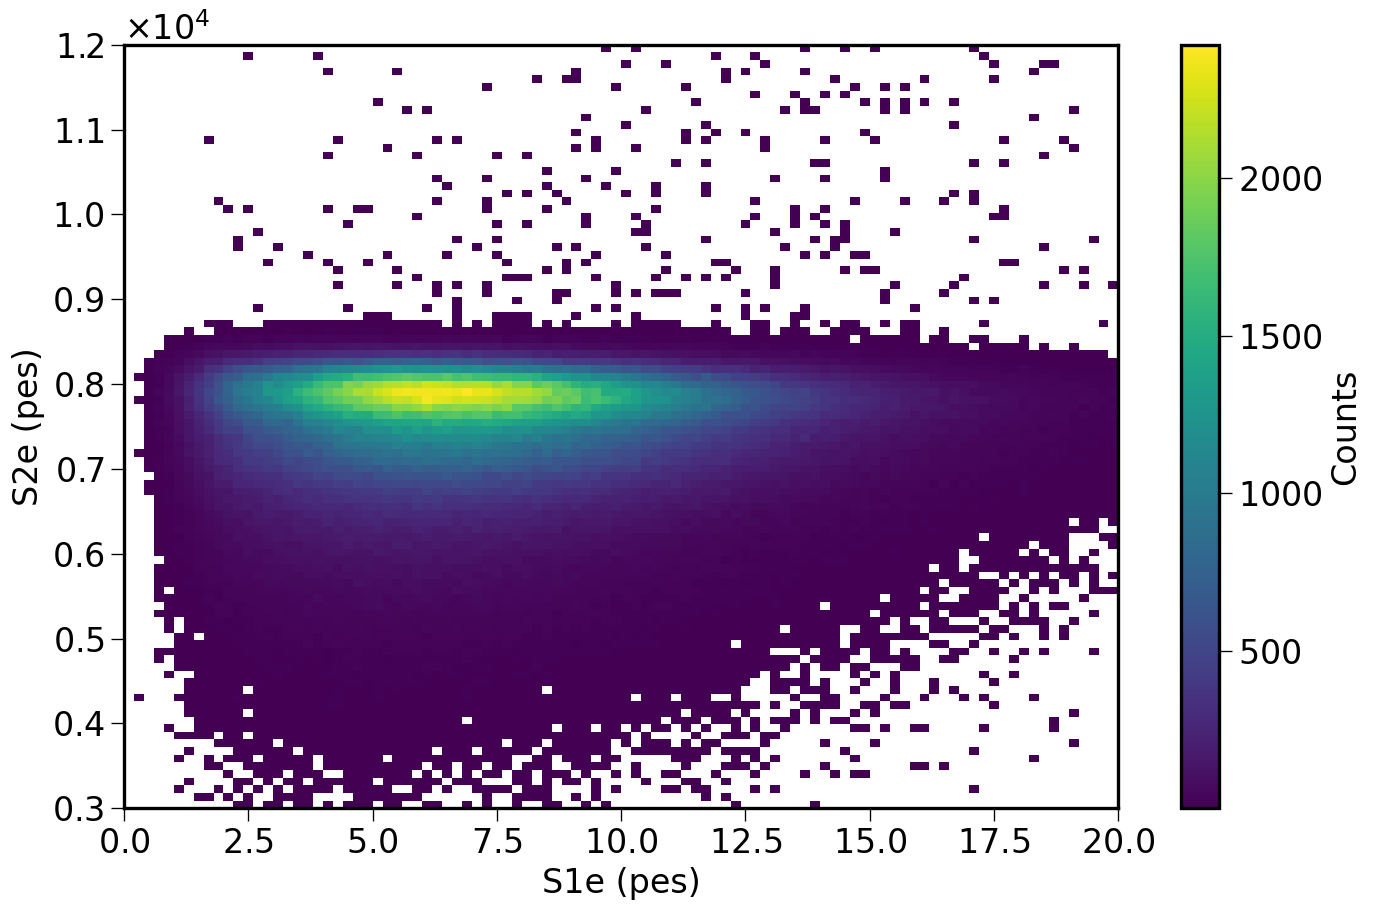

In [12]:
plt.figure(figsize=(12, 8), dpi=120)

counts, xedges, yedges = np.histogram2d(
    df_single_s1_peak_geo['S1e'],
    df_single_s1_peak_geo['S2e'],
    bins=100,
    range=[(0, 20), (3000, 12000)]
)

# Mask bins with counts < 1
counts_masked = np.where(counts < 1, np.nan, counts)

# Plot with pcolormesh
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, counts_masked.T, cmap='viridis', shading='auto')  # transpose counts to align axes

plt.colorbar(label='Counts')
plt.xlabel('S1e (pes)')
plt.ylabel('S2e (pes)')
plt.tight_layout()
plt.show()

/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_80350/2560408748.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_s1_peak_geo['R'] = np.sqrt(df_single_s1_peak_geo['X']**2 + df_single_s1_peak_geo['Y']**2)


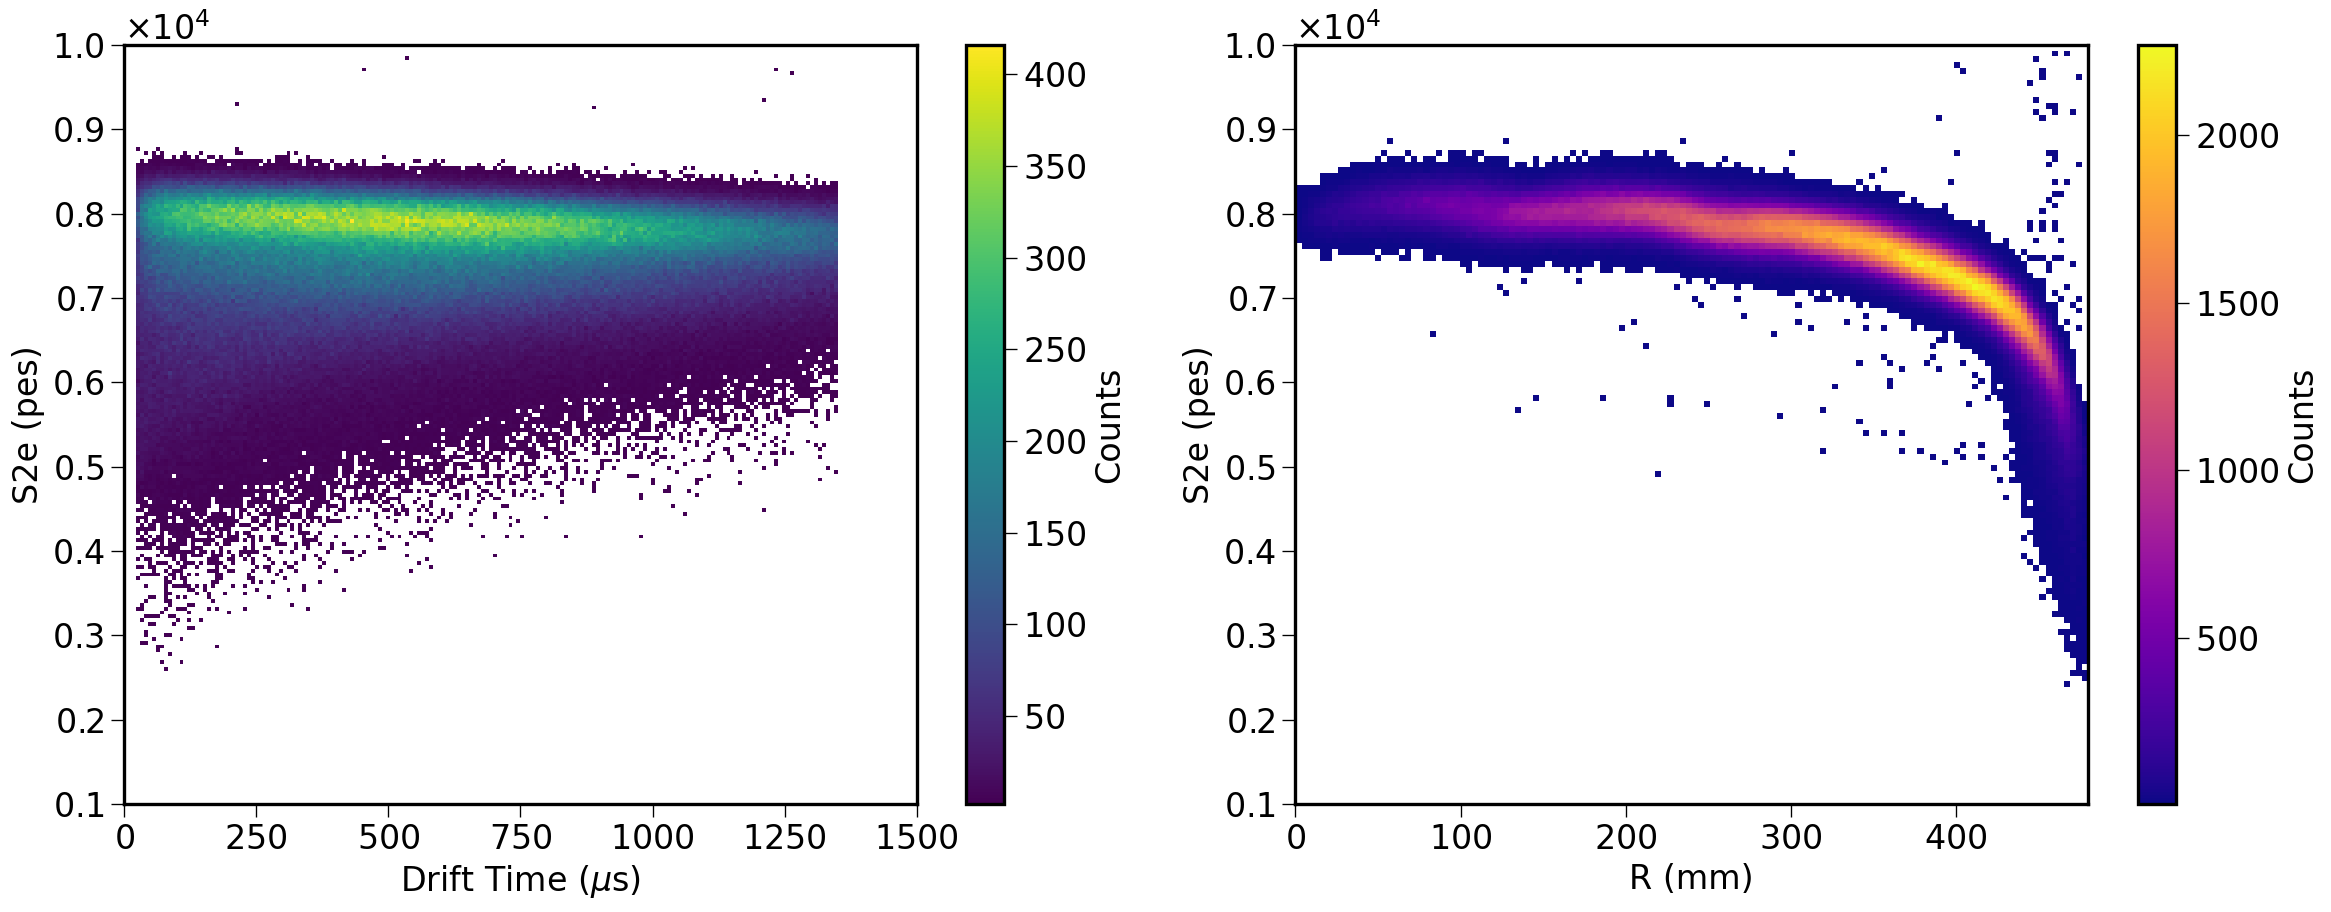

In [13]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8),dpi=120)

df_single_s1_peak_geo['R'] = np.sqrt(df_single_s1_peak_geo['X']**2 + df_single_s1_peak_geo['Y']**2)

# Plot 1: DT vs S2e
counts1, xedges1, yedges1 = np.histogram2d(df_single_s1_peak_geo['DT'], df_single_s1_peak_geo['S2e'], bins=200, range=([0, 1500], [1000, 10000]))
counts1[counts1 <= 1] = np.nan  # Mask bins with counts ≤ 1

axes[0].pcolormesh(xedges1, yedges1, counts1.T, cmap='viridis')
axes[0].set_xlabel('Drift Time ($\mu$s)')
axes[0].set_ylabel('S2e (pes)')
fig.colorbar(axes[0].collections[0], ax=axes[0], label='Counts')

# Compute histogram
counts2, xedges2, yedges2 = np.histogram2d(
    df_single_s1_peak_geo['R'],
    df_single_s1_peak_geo['S2e'],
    bins=130,
    range=([0, 480], [1000, 10000])
)

# Plot 2: sqrt(X^2 + Y^2) vs S2e
counts2, xedges2, yedges2 = np.histogram2d(df_single_s1_peak_geo['R'], df_single_s1_peak_geo['S2e'], bins=130, range=([0, 480], [1000, 10000]))
counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

axes[1].pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
axes[1].set_xlabel('R (mm)')
axes[1].set_ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

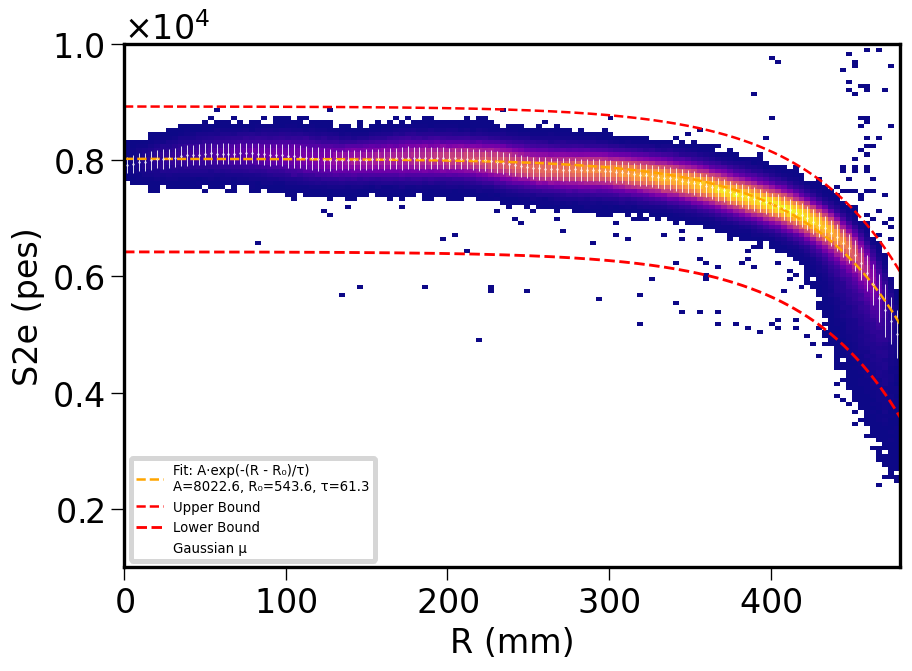

In [14]:
# Step 3: Fit with exponential model
def expo_model(R, A, R0, tau):
    return A *(1- np.exp((R - R0) / tau))

plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(df_single_s1_peak_geo['R'], df_single_s1_peak_geo['S2e'], bins=130, range=([0, 480], [1000, 10000]))
dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts2, xedges2, yedges2)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

p0=[8000, 600, 100]
popt, _ = curve_fit(expo_model, dt_centers, mean_vals, p0=p0)

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(dt_centers, mean_vals, yerr=sigma, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')

r_fit = np.linspace(0, 480, 500)
plt.plot(r_fit, expo_model(r_fit, *popt), color='orange', linestyle='--', linewidth=1.5, label=f'Fit: A·exp(-(R - R₀)/τ)\nA={popt[0]:.1f}, R₀={popt[1]:.1f}, τ={popt[2]:.1f}')
plt.plot(r_fit, expo_model(r_fit, *popt)+900, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound')
plt.plot(r_fit, expo_model(r_fit, *popt)-1600, color='red', linestyle='--', linewidth=1.7, label=f'Lower Bound')

plt.legend(fontsize=8)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [41]:
Krdf = df_single_s1_peak_geo[(df_single_s1_peak_geo['S2e'] >= expo_model(df_single_s1_peak_geo['R'], *popt) - 1600) & 
                             (df_single_s1_peak_geo['S2e'] <= expo_model(df_single_s1_peak_geo['R'], *popt) + 900)]

print(f"NEvent filtered road : {len(np.unique(Krdf['event']))}")
print(f"eff:{(len(np.unique(Krdf['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 1103311
eff:38.81%


In [42]:
bins_xy = 100
z_bins = np.array([])
z_bins = np.append(z_bins, 0)
z_bins = np.append(z_bins, np.linspace(200, 1050, 9))
z_bins = np.append(z_bins, 1350)

print(z_bins)
krmap = af.compute_map3D(Krdf, bins_xy = bins_xy, z_bins=z_bins)

[   0.    200.    306.25  412.5   518.75  625.    731.25  837.5   943.75
 1050.   1350.  ]


In [43]:
max_index = np.unravel_index(np.argmax(krmap.hratio), krmap.hratio.shape)
hmap = np.divide(krmap.hratio, krmap.hratio[max_index], where=krmap.hcounts > 2)
krmap.hmap = hmap

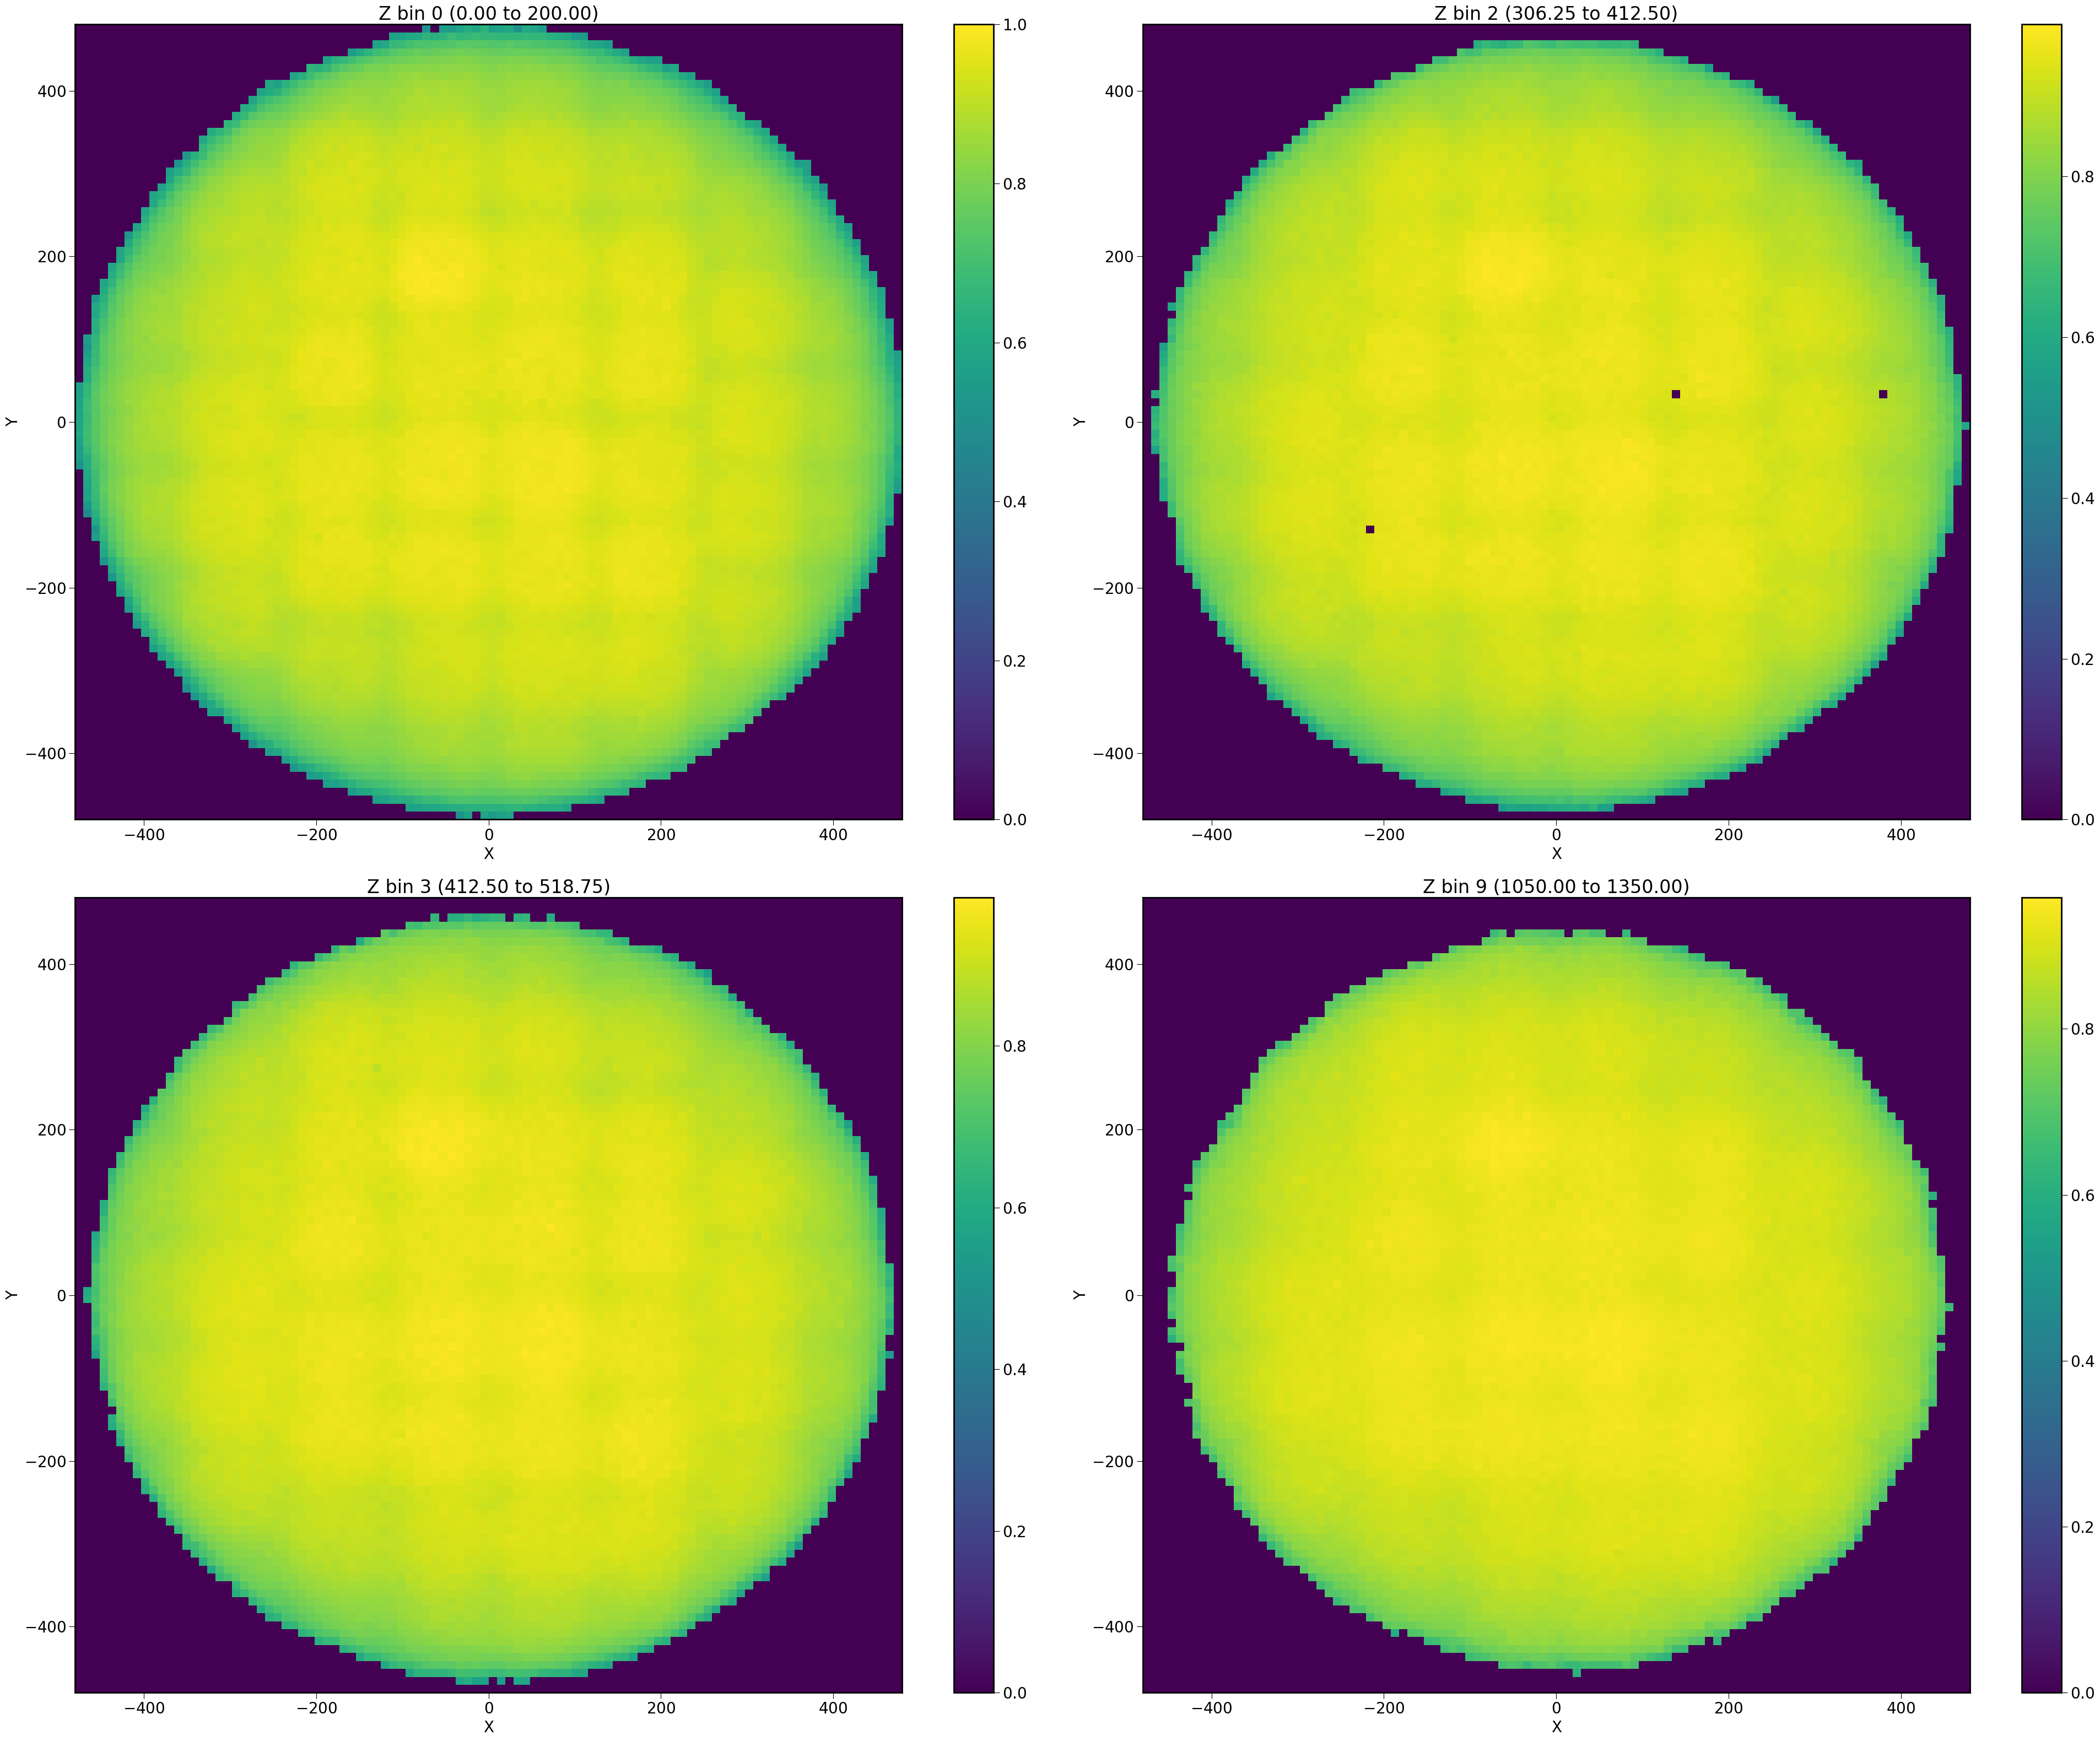

In [44]:
af.plot_3d_histogram_slices(krmap.hmap, krmap.xedges, krmap.yedges, krmap.zedges, z_indices=[0,2,3,len(z_bins)-2], figsize= (20, 16))

In [28]:
#krmap = af.load_kr_map("../db/kr_maps/map_run15504_V2.npz")
#Krdf = af.correct_S2e(Krdf, krmap, rmax=480.0, zmax=1350.0)

In [29]:
af.save_kr_map(krmap,f"../db/kr_maps/map_run{run_number}_V2.npz")

In [30]:
Krdf

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
7,20,1.749037e+09,0,0,1,1,350.0,1.402740,7.584902,160650.0,...,15,1242.828125,1242.828125,6.430414,96.939760,-176.244570,201.145384,-1.067930,14.966450,14.620376
10,34,1.749037e+09,0,0,1,1,300.0,1.682694,8.687951,1242000.0,...,18,162.490875,162.490875,2.257073,18.893501,223.647120,224.443754,1.486517,11.745563,14.396015
11,41,1.749037e+09,0,0,1,1,125.0,0.740590,2.684842,632400.0,...,21,771.061646,771.061646,5.060041,10.526505,114.157632,114.641931,1.478846,15.352800,16.823175
15,55,1.749037e+09,0,0,1,1,250.0,2.418109,12.236946,1340475.0,...,18,63.028130,63.028130,1.694145,104.697731,-226.509115,249.535557,-1.137824,11.745195,12.472256
21,76,1.749037e+09,0,0,1,1,275.0,1.997608,12.155931,405600.0,...,18,996.889160,996.889160,5.711484,212.154677,-179.338129,277.798077,-0.701770,17.095555,16.113673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074349,3197085,1.749122e+09,0,0,1,1,275.0,1.272343,7.102973,690300.0,...,14,709.179260,709.179260,4.723540,168.952783,70.268991,182.982988,0.394145,14.000119,12.732606
7074350,3197092,1.749122e+09,0,0,1,1,250.0,1.510351,6.083881,1154375.0,...,17,249.090256,249.090256,2.820357,382.869668,-151.899078,411.901095,-0.377691,13.430446,13.627971
7074351,3197106,1.749122e+09,0,0,1,1,175.0,1.047801,5.725581,909725.0,...,16,493.753021,493.753021,4.166740,10.524896,98.498029,99.058746,1.464346,14.349134,14.173232
7074354,3197120,1.749122e+09,0,0,1,1,225.0,0.507761,3.482136,797950.0,...,17,603.529785,603.529785,4.404386,-108.817875,-227.316900,252.020441,-2.017264,15.874735,12.466383


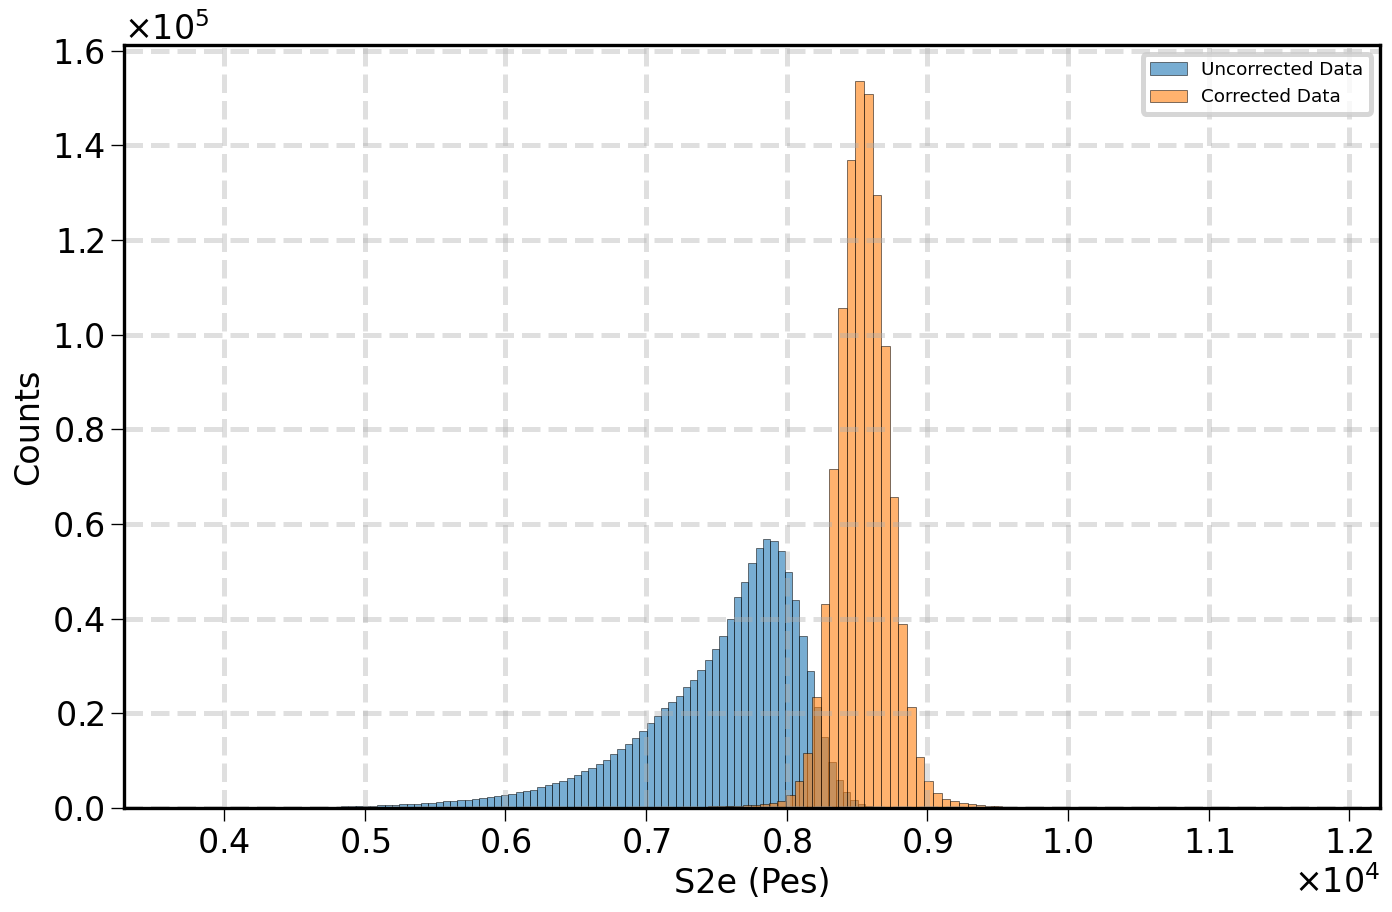

In [280]:
plt.figure(figsize=(12, 8), dpi=120)

# Plot S2e histogram
plt.hist(Krdf['S2e'], bins=100, alpha=0.6, color='tab:blue', edgecolor='black', linewidth=0.5, label='Uncorrected Data')

# Plot Epes histogram
plt.hist(Krdf['Epes'], bins=100, alpha=0.6, color='tab:orange', edgecolor='black', linewidth=0.5, label='Corrected Data')

# Aesthetic settings
plt.xlabel('S2e (Pes)')
plt.ylabel('Counts')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

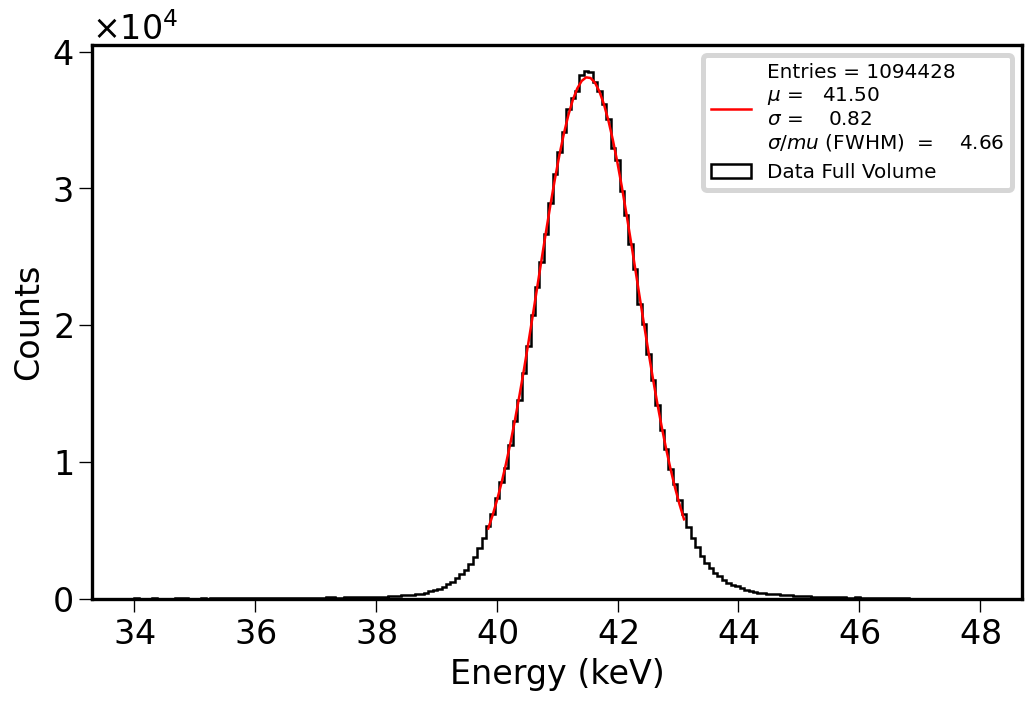

In [281]:
hp = af.HistoPar(var = Krdf['Epes']/Krdf['Epes'].mean()*41.5, nbins = 190, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 1.7)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data Full Volume")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

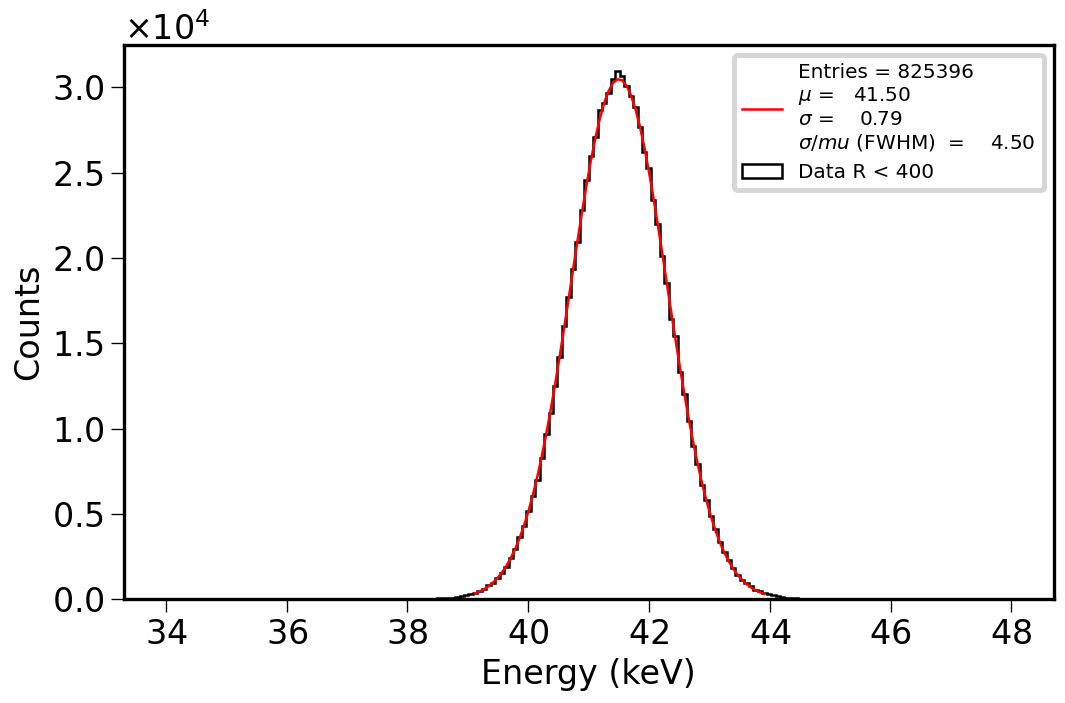

In [282]:
hp = af.HistoPar(var = Krdf[Krdf['R']<400]['Epes']/Krdf[Krdf['R']<400]['Epes'].mean()*41.5, nbins = 190, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 400")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

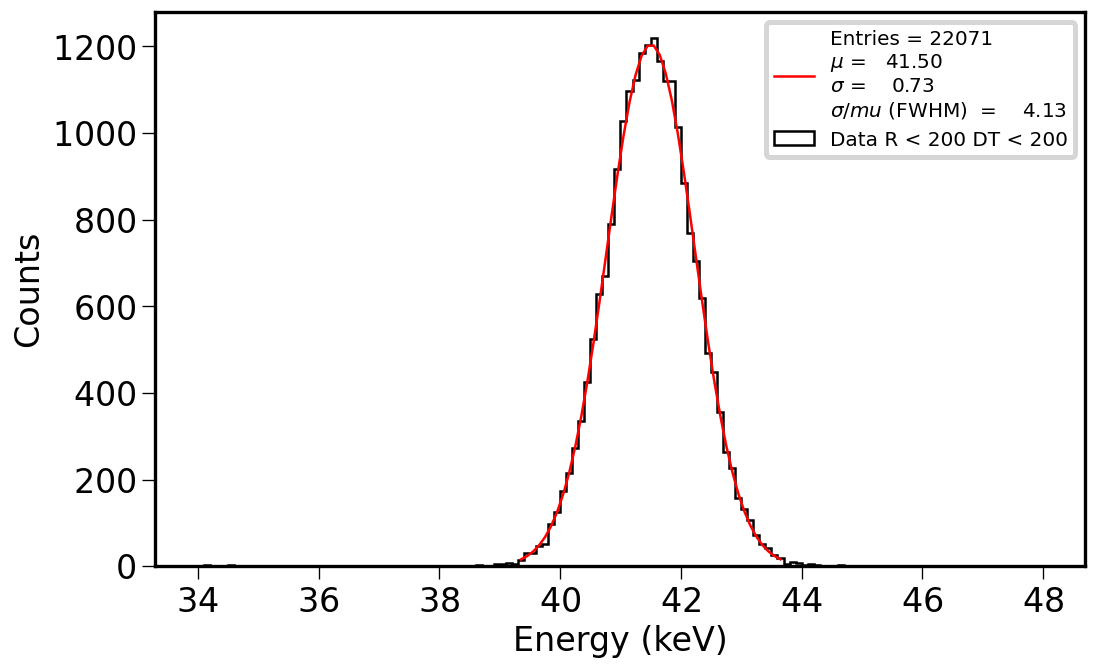

In [283]:
hp = af.HistoPar(var = Krdf[(Krdf['R']<200) & (Krdf['DT']<200)]['Epes']/Krdf[(Krdf['R']<200) & (Krdf['DT']<200)]['Epes'].mean()*41.5, nbins =140, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 200 DT < 200")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

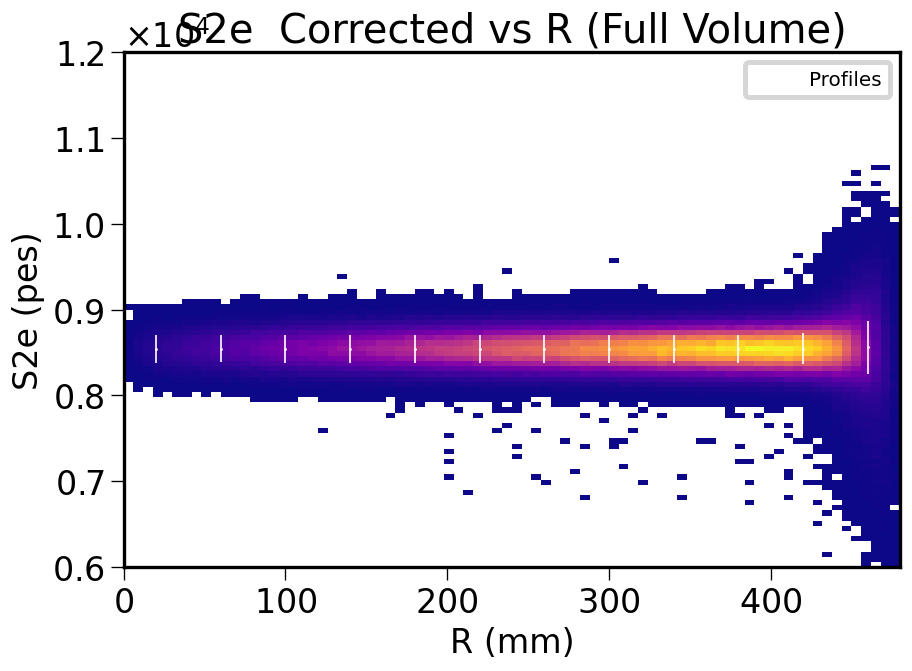

In [284]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf['R'], Krdf['Epes'], bins=(80,100), range=([0, 480], [6000, 12000]))
r_centers, mean_vals_full_dt, mean_errs_full_dt, sigma_full_dt, sigma_errs_full_dt = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(r_centers, mean_vals_full_dt, yerr=sigma_full_dt, fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.title('S2e  Corrected vs R (Full Volume)')
plt.legend(fontsize=12)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

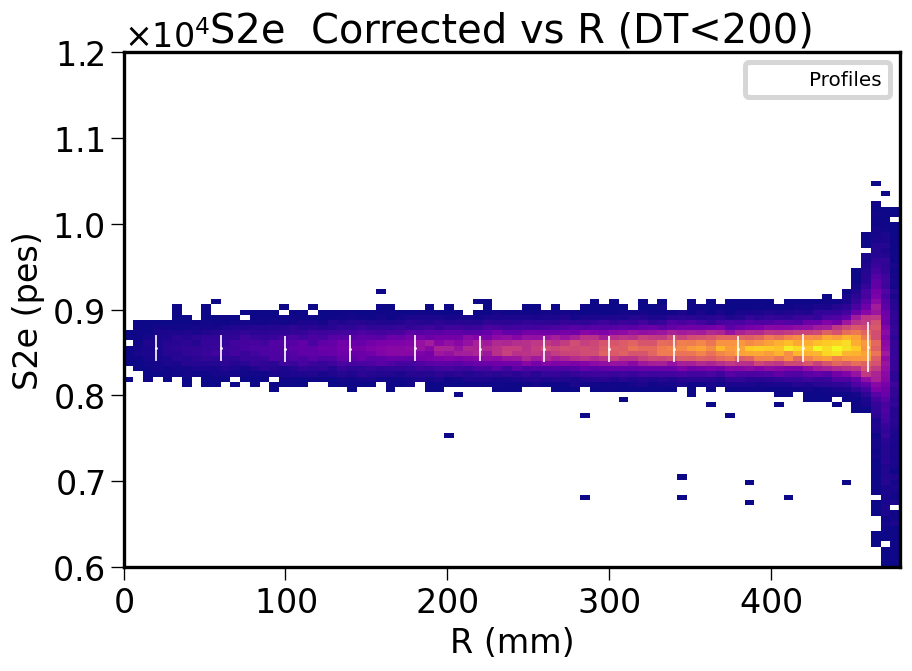

In [285]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['DT']<200]['R'], Krdf[Krdf['DT']<200]['Epes'], bins=(80,100), range=([0, 480], [6000, 12000]))
r_centers, mean_vals_small_dt, mean_errs_small_dt, sigma_small_dt, sigma_errs_small_dt = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(r_centers, mean_vals_small_dt, yerr=sigma_small_dt, fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.legend(fontsize=12)
plt.title('S2e  Corrected vs R (DT<200)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

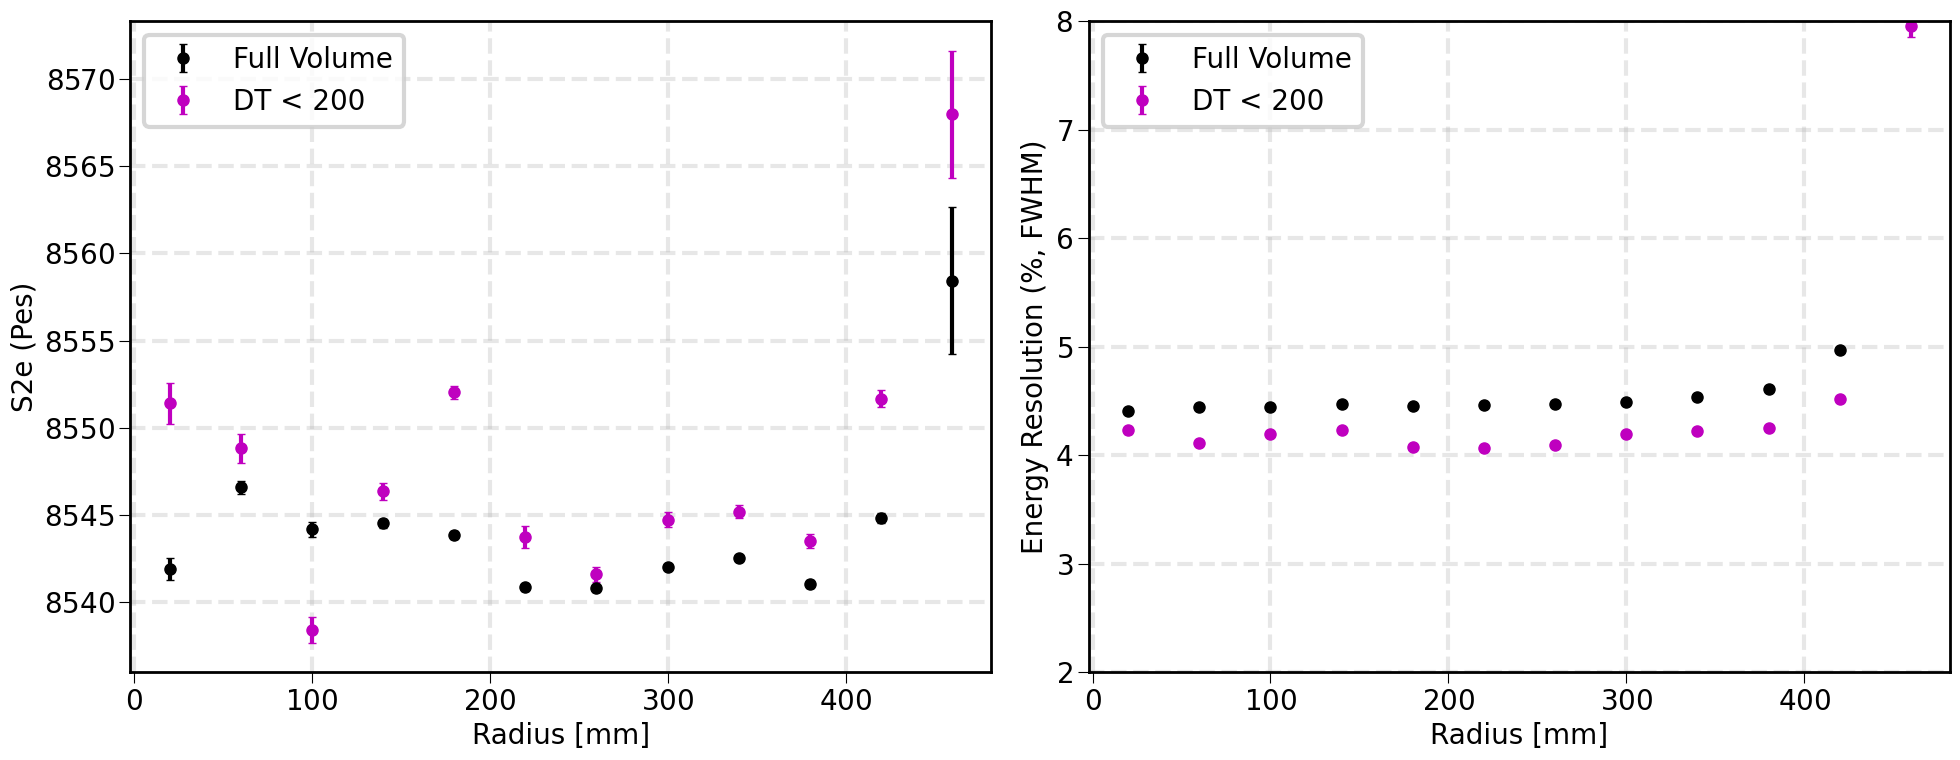

In [286]:
resolution_full, resolution_err_full = stats.compute_resolution_with_error(sigma_full_dt, sigma_errs_full_dt, mean_vals_full_dt, mean_errs_full_dt)
resolution_small, resolution_err_small = stats.compute_resolution_with_error(sigma_small_dt, sigma_errs_small_dt, mean_vals_small_dt, mean_errs_small_dt)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Mean vs. r_centers
ax1.errorbar(r_centers, mean_vals_full_dt, yerr=mean_errs_full_dt,
             fmt='o', capsize=3, markersize=8., label='Full Volume', color=color_sequence[0])
ax1.errorbar(r_centers, mean_vals_small_dt, yerr=mean_errs_small_dt,
             fmt='o', capsize=3, markersize=8., label='DT < 200', color=color_sequence[1])
ax1.set_xlabel('Radius [mm]')
ax1.set_ylabel('S2e (Pes)')
ax1.grid(True, alpha=0.3)
#ax1.set_ylim(8680,8750)
ax1.legend()

# Plot 2: Resolution vs. r_centers
ax2.errorbar(r_centers, resolution_full, yerr=resolution_err_full,
             fmt='o', capsize=3, markersize=8., color=color_sequence[0], label='Full Volume')
ax2.errorbar(r_centers, resolution_small, yerr=resolution_err_small,
             fmt='o', capsize=3, markersize=8., color=color_sequence[1], label='DT < 200')
ax2.set_xlabel('Radius [mm]')
ax2.set_ylabel('Energy Resolution (%, FWHM)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(2,8)
ax2.legend()

plt.tight_layout()
plt.show()

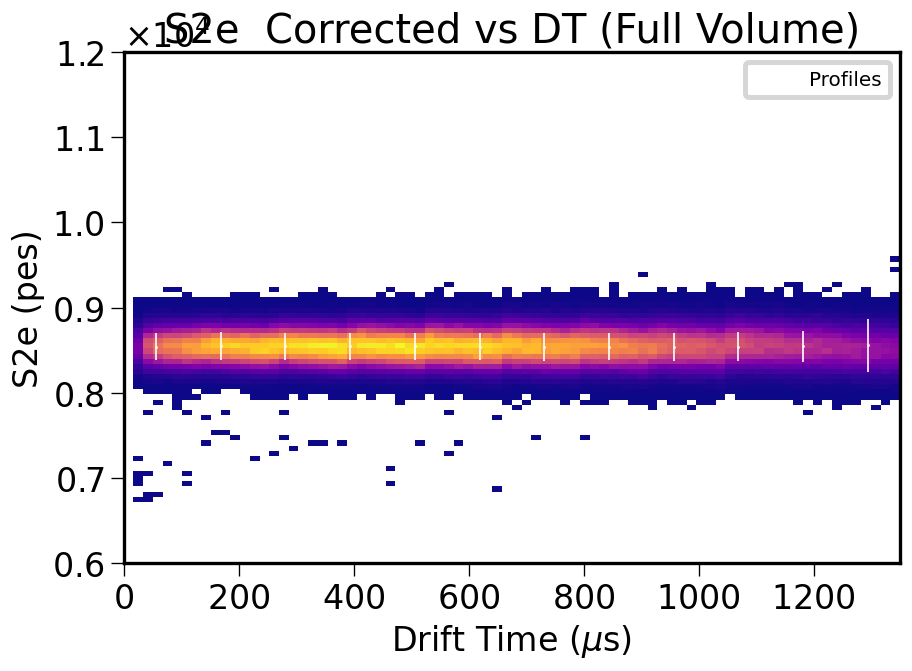

In [287]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['R']<400]['DT'], Krdf[Krdf['R']<400]['Epes'], bins=(80,100), range=([0, 1350], [6000, 12000]))
dt_centers, mean_vals_full_r, mean_errs_full_r, sigma_full_r, sigma_errs_full_r = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(dt_centers, mean_vals_full_dt, yerr=sigma_full_dt, fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.legend(fontsize=12)
plt.title('S2e  Corrected vs DT (Full Volume)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

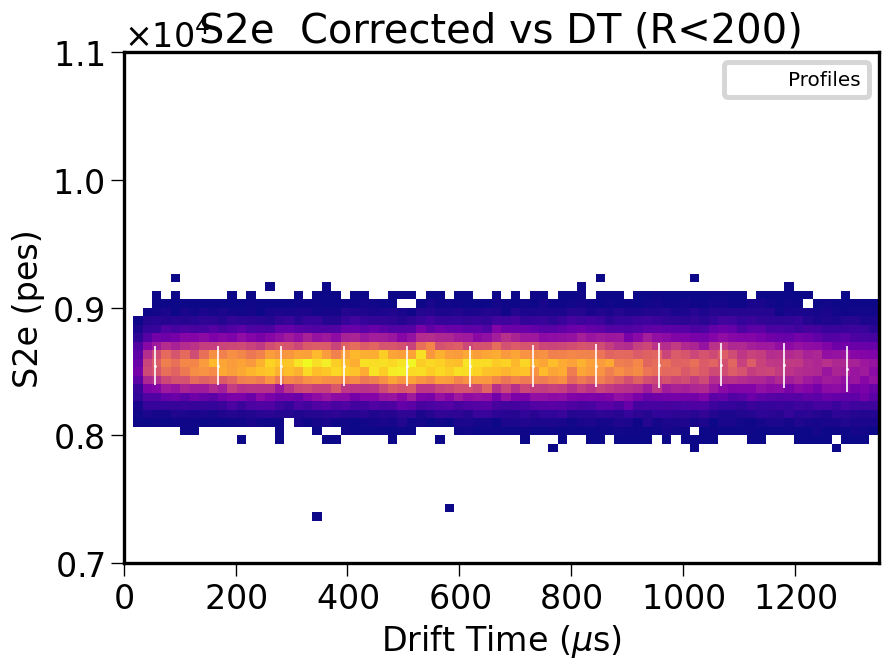

In [288]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['R']<200]['DT'], Krdf[Krdf['R']<200]['Epes'], bins=(80,60), range=([0, 1350], [7000, 11000]))
dt_centers, mean_vals_small_r, mean_errs_small_r, sigma_small_r, sigma_errs_small_r = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(dt_centers, mean_vals_small_r, yerr=sigma_small_r, fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.legend(fontsize=12)
plt.title('S2e  Corrected vs DT (R<200)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

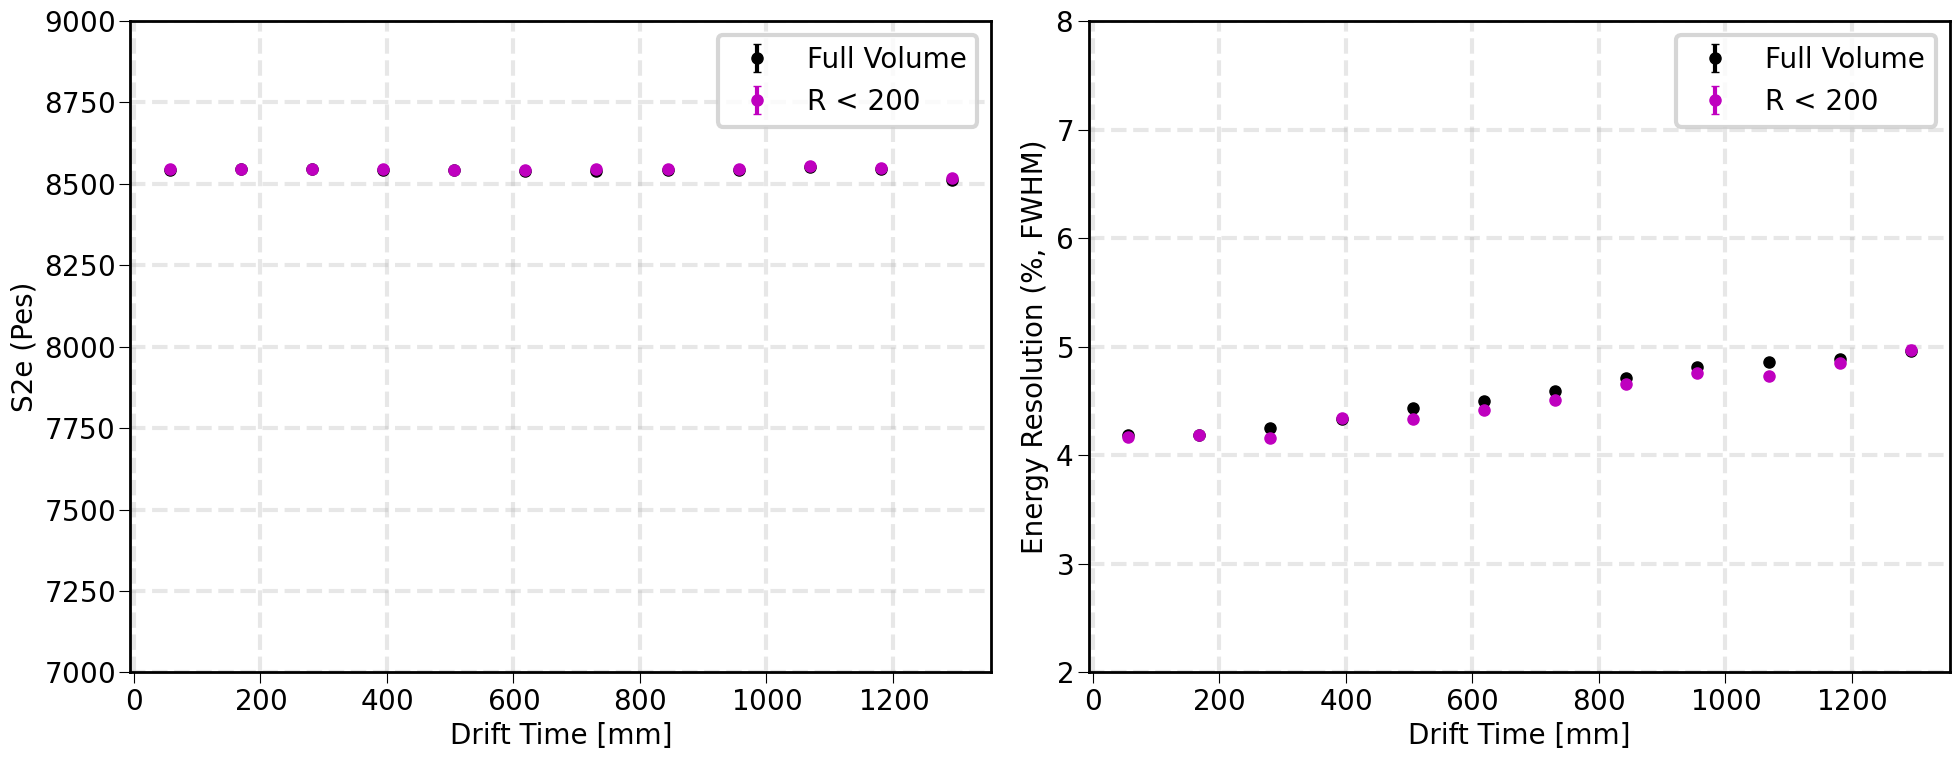

In [289]:
resolution_full, resolution_err_full = stats.compute_resolution_with_error(sigma_full_r, sigma_errs_full_r, mean_vals_full_r, mean_errs_full_r)
resolution_small, resolution_err_small = stats.compute_resolution_with_error(sigma_small_r, sigma_errs_small_r, mean_vals_small_r, mean_errs_small_r)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Mean vs. r_centers
ax1.errorbar(dt_centers, mean_vals_full_r, yerr=mean_errs_full_dt,
             fmt='o', capsize=3, markersize=8., label='Full Volume', color=color_sequence[0])
ax1.errorbar(dt_centers, mean_vals_small_r, yerr=mean_errs_small_dt,
             fmt='o', capsize=3, markersize=8., label='R < 200', color=color_sequence[1])
ax1.set_xlabel('Drift Time [mm]')
ax1.set_ylabel('S2e (Pes)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(7000,9000)
ax1.legend()

# Plot 2: Resolution vs. r_centers
ax2.errorbar(dt_centers, resolution_full, yerr=resolution_err_full,
             fmt='o', capsize=3, markersize=8., color=color_sequence[0], label='Full Volume')
ax2.errorbar(dt_centers, resolution_small, yerr=resolution_err_small,
             fmt='o', capsize=3, markersize=8., color=color_sequence[1], label='R < 200')
ax2.set_xlabel('Drift Time [mm]')
ax2.set_ylabel('Energy Resolution (%, FWHM)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(2,8)
ax2.legend()

plt.tight_layout()
plt.show()

### DT Resolution Noise Correction

In [205]:
df_resonoise = pd.read_hdf("../db/NoiseResoEffect.h5")

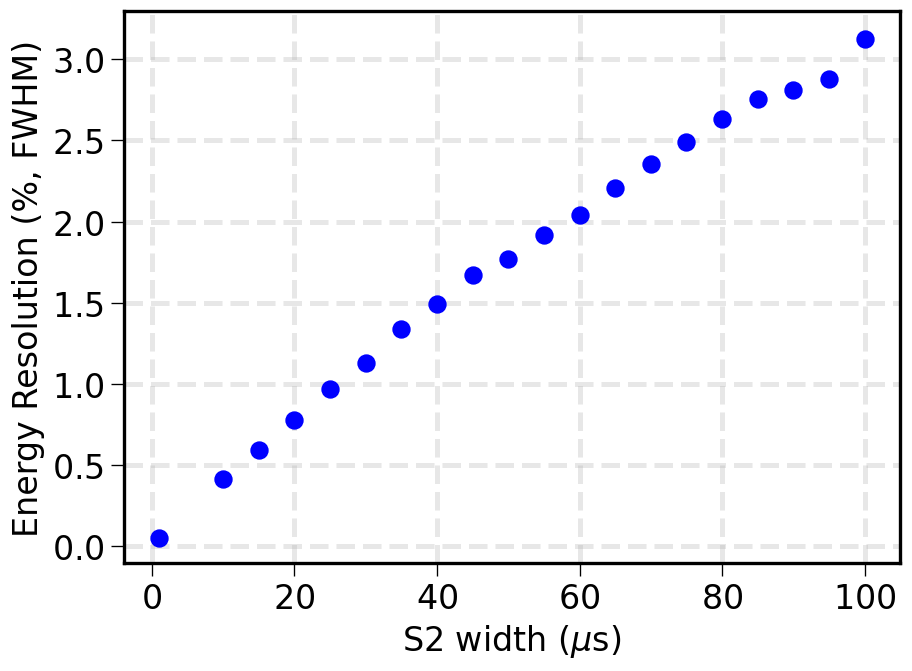

In [206]:
# Constants
E0 = Krdf['Epes'].mean()

# Compute y values and errors
y = 235 * df_resonoise["sig"] / E0
yerr = 235 * df_resonoise["usig"] / E0
x = df_resonoise["sz"]

# Get sorting indices based on x
sorted_indices = np.argsort(x)

# Apply sorting
x = x.values[sorted_indices]
y = y.values[sorted_indices]
yerr = yerr.values[sorted_indices]

# Plot
plt.figure(figsize=(8, 6), dpi=120)

plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=10.,capsize=3, color='b')
plt.xlabel('S2 width ($\mu$s)')
plt.ylabel(r'Energy Resolution (%, FWHM)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

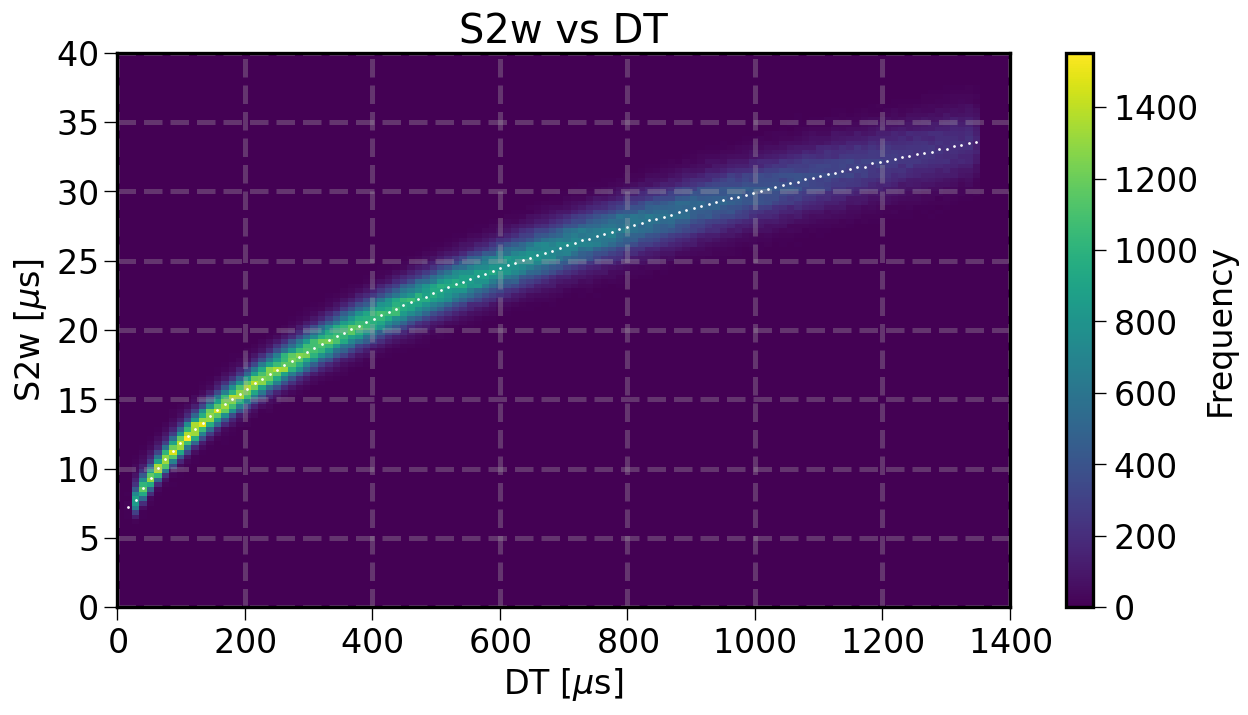

In [207]:
plt.figure(figsize=(12, 6), dpi=120)
hist, xedges, yedges, im = plt.hist2d(Krdf['DT'], Krdf['S2w'],
                                      bins=(120, 120),
                                      range=([0, 1400], [0, 40]),
                                      cmap='viridis')

results = af.gaussian_profiler_y(hist, xedges, yedges)
xdata = results[0]
ydata = results[1]

# Get sorted indices
sorted_indices = np.argsort(xdata)

# Sort both xdata and ydata using the indices
xdata = xdata[sorted_indices]
ydata = ydata[sorted_indices]

plt.errorbar(xdata, ydata, yerr=None, fmt='.', markersize=1.3, linewidth=1., color='w', label='Gauss Fit results')

plt.colorbar(label='Frequency')
plt.xlabel('DT [$\mu$s]')
plt.ylabel('S2w [$\mu$s]')
plt.title('S2w vs DT')
plt.grid(True, alpha=0.3)

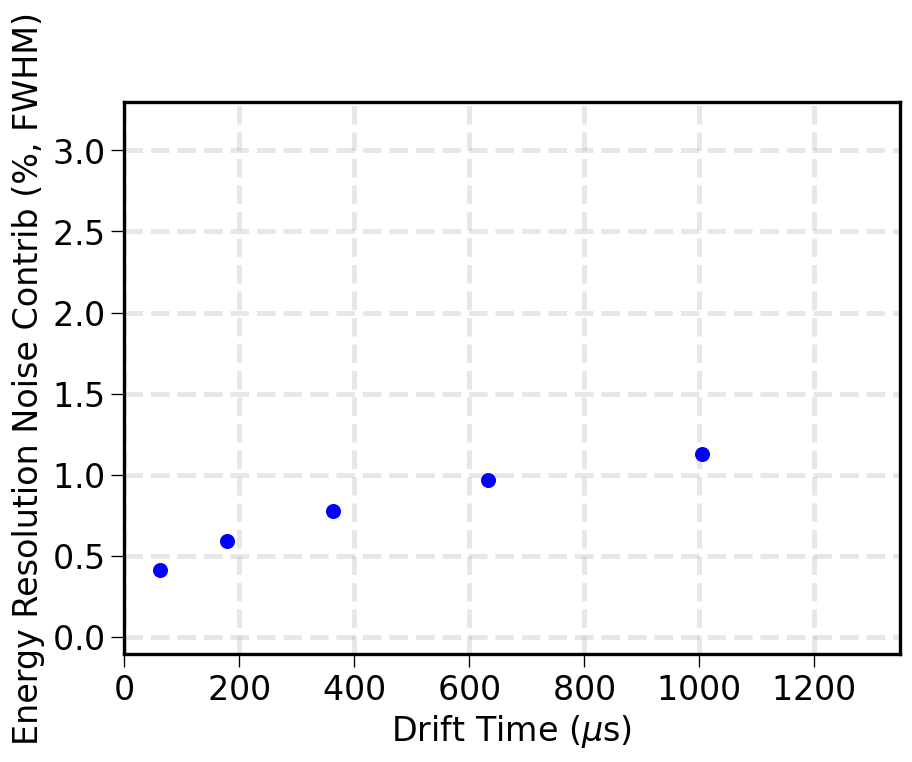

In [208]:
plt.figure(figsize=(8, 6), dpi=120)

# Create interpolation function: DT as a function of S2w
interp_func = interp1d(ydata, xdata, kind='linear', bounds_error=False, fill_value='extrapolate')

# Now transform x (S2w values) to DT values
x_transformed = interp_func(x)  # These are now DT values

plt.errorbar(x_transformed, y, yerr=yerr, fmt='o', markersize=8., capsize=3, color='b')
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel(r'Energy Resolution Noise Contrib (%, FWHM)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(0,1350)
plt.show()

In [209]:
# Create the interpolation function from EReso vs DT
interp_func = interp1d(x_transformed, y, kind='linear', bounds_error=False, fill_value='extrapolate')

# Interpolate at slice_centers of the EReso vs Dt Plot
y_interp = interp_func(dt_centers)

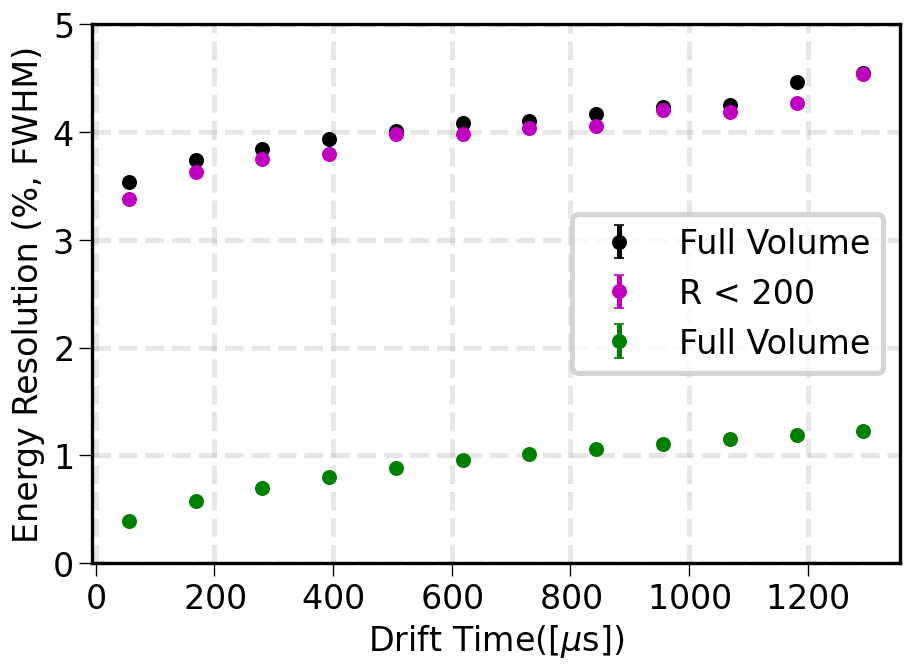

In [210]:
# Plot Full Volume
plt.figure(figsize=(8, 6), dpi=120)

# Plot 2: Resolution vs. r_centers
plt.errorbar(dt_centers, resolution_full, yerr=resolution_err_full,
             fmt='o', capsize=3, markersize=8., color=color_sequence[0], label='Full Volume')
plt.errorbar(dt_centers, resolution_small, yerr=resolution_err_small,
             fmt='o', capsize=3, markersize=8., color=color_sequence[1], label='R < 200')

# Plot interpolated values (assumed to be y_interp vs slice_centers)
plt.errorbar(dt_centers,y_interp, yerr=0,
    fmt='o', capsize=3, markersize=8., color=color_sequence[2], label='Full Volume')


# Labels, legend, etc.
plt.xlabel('Drift Time([$\mu$s])')
plt.ylabel('Energy Resolution (%, FWHM)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0,5)
plt.tight_layout()
plt.show()

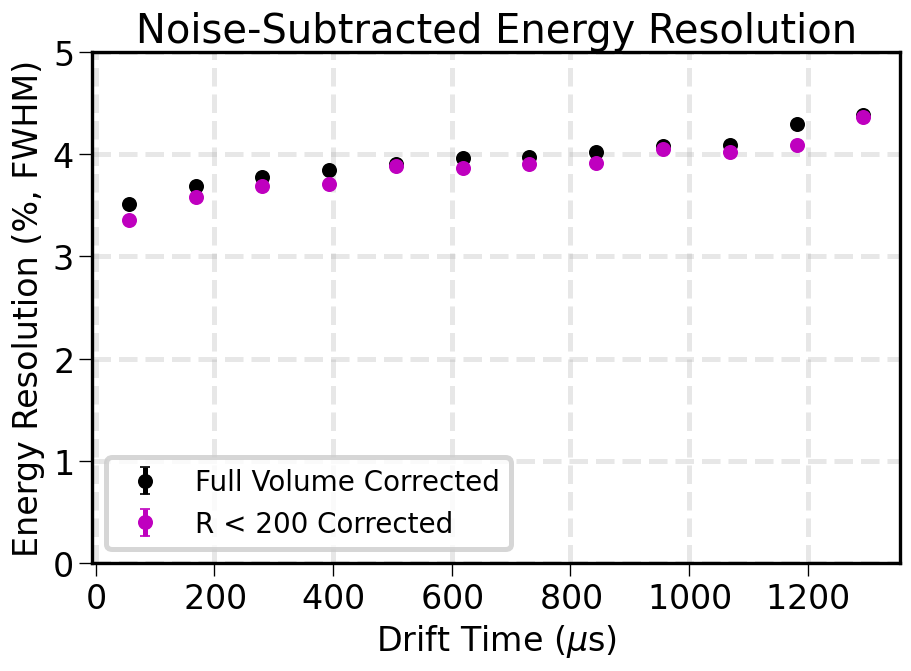

In [211]:
plt.figure(figsize=(8, 6), dpi=120)

# Full Volume: sqrt(mean² - y_interp²)
res_full = np.sqrt(np.square(resolution_full) - np.square(y_interp))
plt.errorbar(
    dt_centers,
    res_full,
    yerr=resolution_err_full,
    fmt='o', capsize=3, markersize=8.,
    color='k',
    label='Full Volume Corrected'
)

# Small R: sqrt(mean² - y_interp²)
res_smallR = np.sqrt(np.square(resolution_small) - np.square(y_interp))
plt.errorbar(
    dt_centers,
    res_smallR,
    yerr=resolution_err_small,
    fmt='o', capsize=3, markersize=8.,
    color='m',
    label='R < 200 Corrected'
)

# Final touches
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('Energy Resolution (%, FWHM)')
plt.title('Noise-Subtracted Energy Resolution')
plt.grid(True, alpha=0.3)
plt.ylim(0,5)
plt.legend(fontsize='small')
plt.tight_layout()
plt.show()

### Radial response analysis in angular sectors 

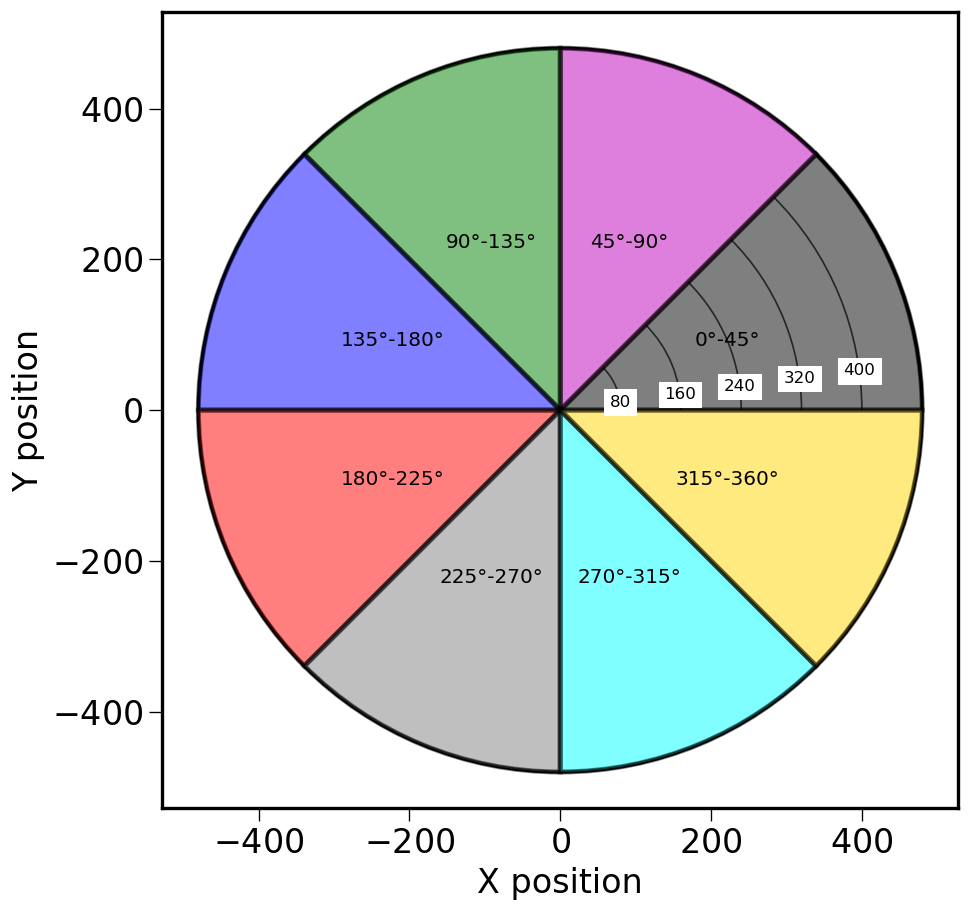

In [212]:
sector_angle = 45 #Degrees
radial_bins_per_sector= 6 #Radial sectors along R

pf.plot_circular_sectors(sector_angle, radial_bins_per_sector, dpi=120)

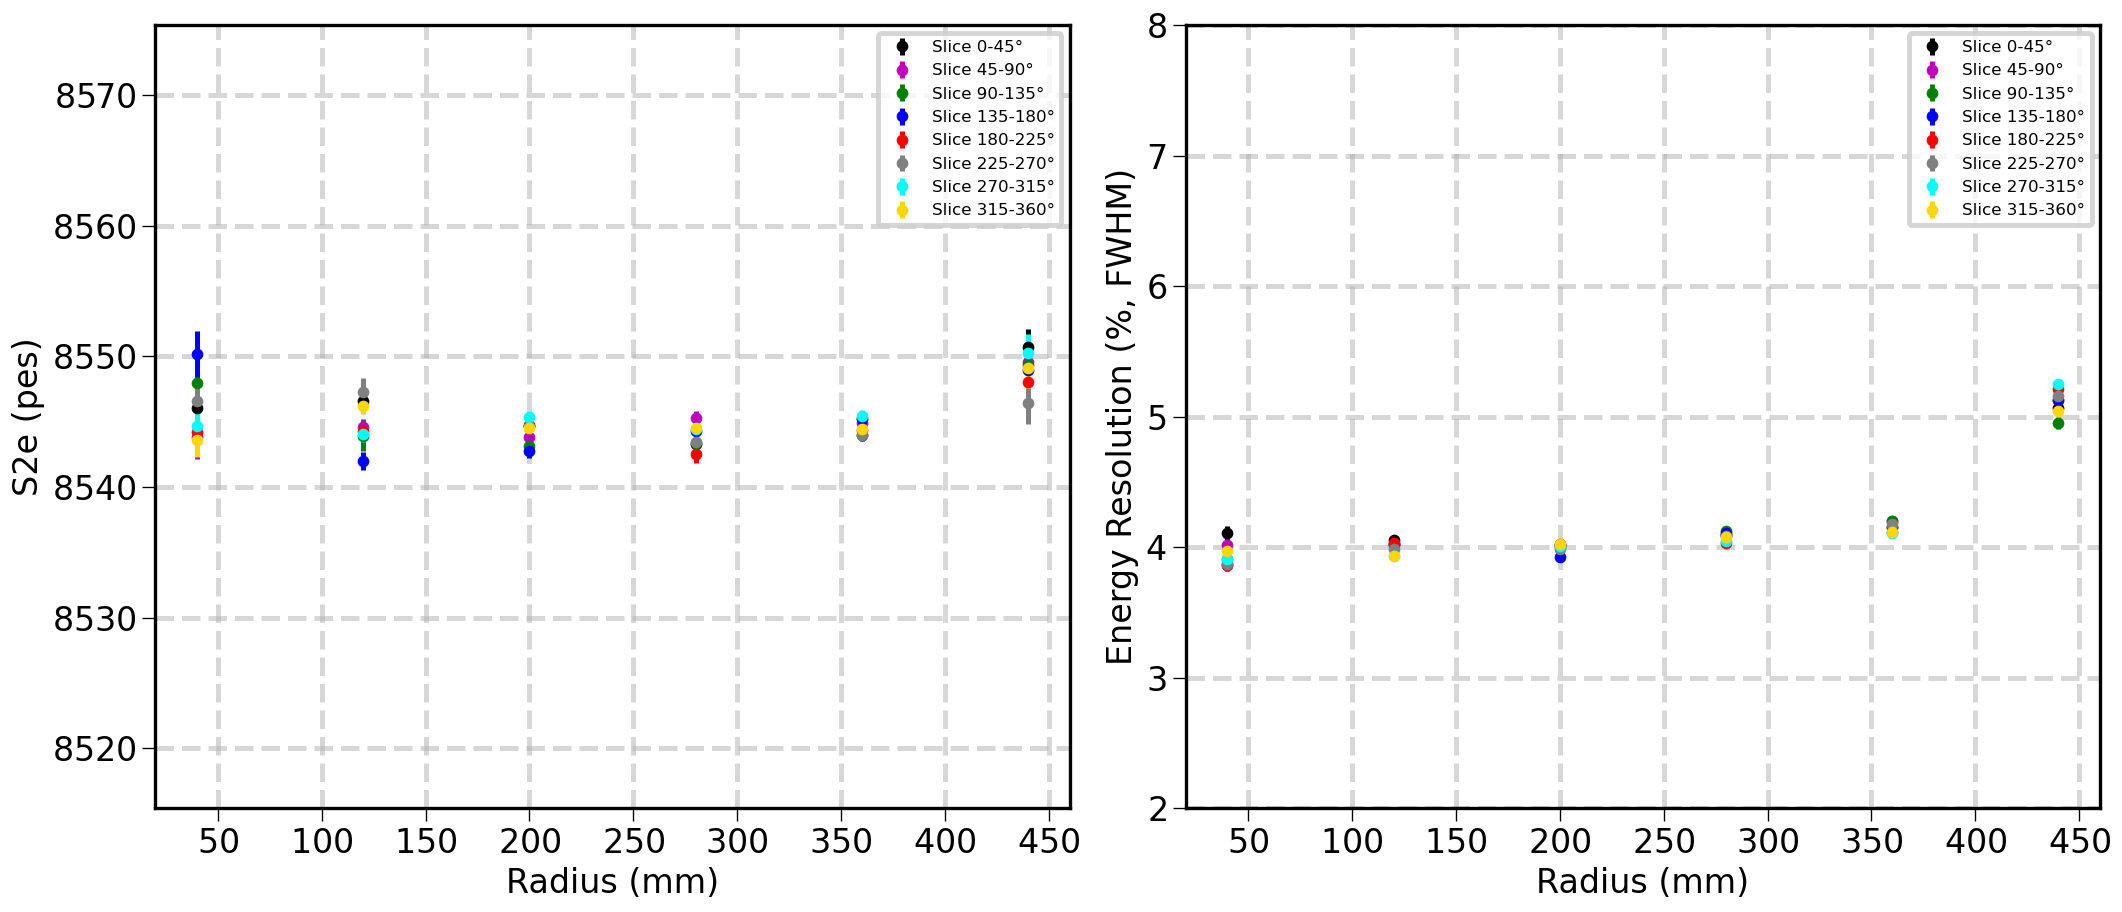

In [213]:
results, r_centers = af.response_in_sector(Krdf, sector_angle, radial_bins_per_sector)
af.plot_response_vs_radius_insector(r_centers, results, sector_angle, stats.compute_resolution_with_error, color_sequence)

### Lifetime

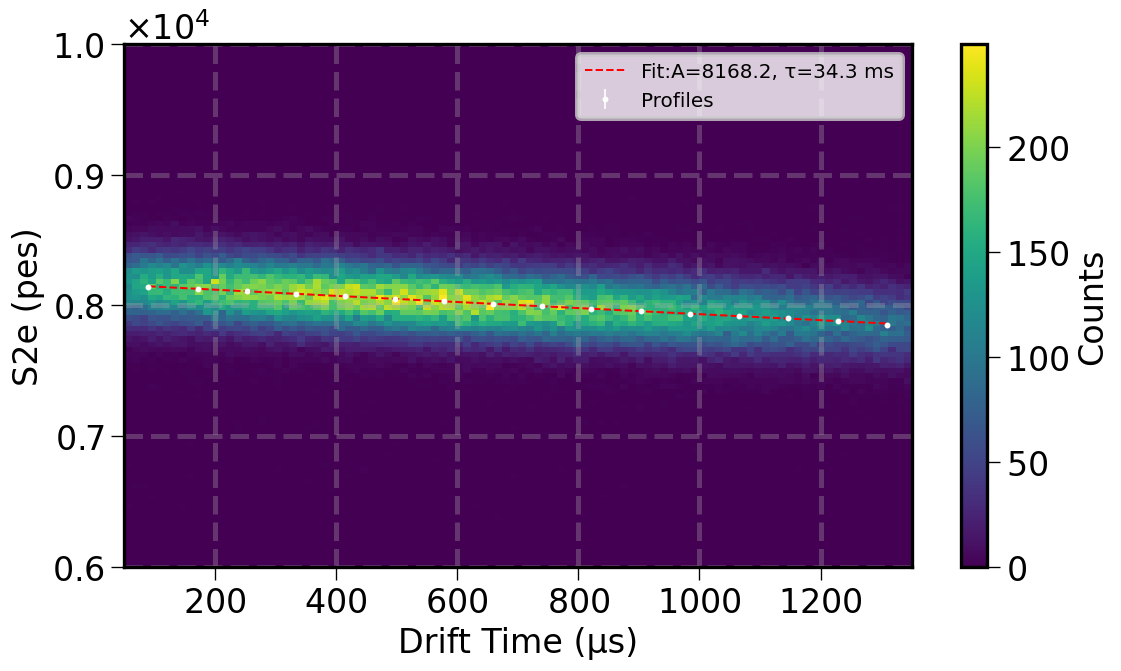

(34310.91523237401, 88.89965867933847)

In [214]:
importlib.reload(af)
af.fit_lifetime_Rsel(Krdf)

In [215]:
### Test map on second dataset

In [236]:
folderdata = ["/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/15502/"]
df_testrun = merge_hdfs_multi(folderdata)

In [237]:
df_test_s1s2 = df_testrun[(df_testrun['nS1']==1) & (df_testrun['nS2']==1)]

print(f"NEvent filtered road : {len(np.unique(df_s1s2['event']))}")
print(f"eff:{(len(np.unique(df_s1s2['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 824595
eff:45.97%


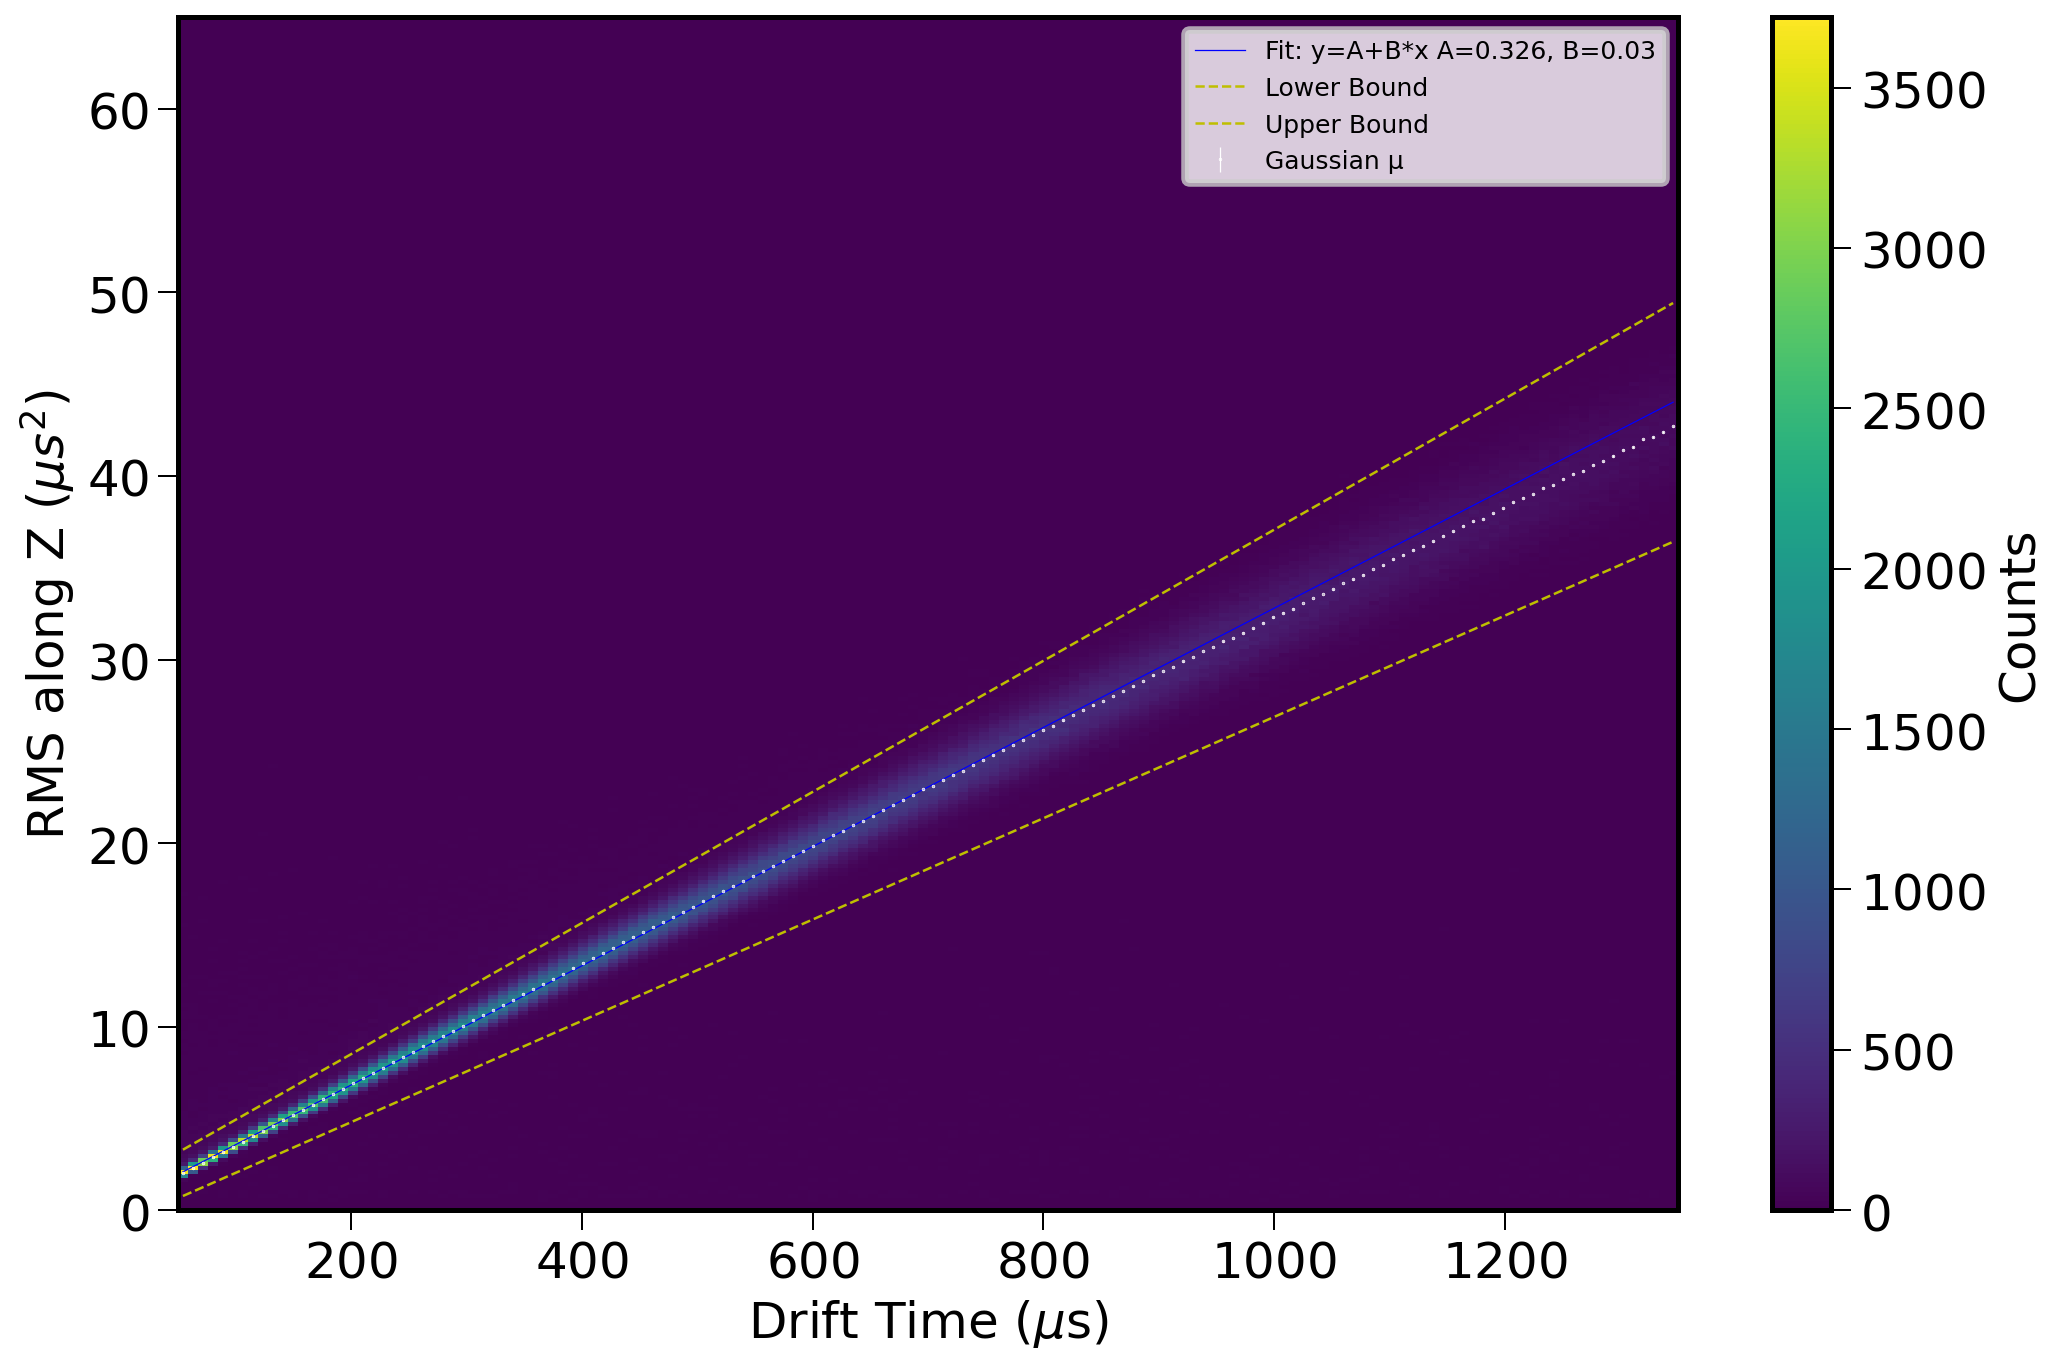

In [238]:
def line_function(x, A, B):
    return A + B*x

counts, xedges, yedges = np.histogram2d(
    df_test_s1s2[df_test_s1s2['DT']>50]['DT'],
    np.square(df_test_s1s2[df_test_s1s2['DT']>50]['Zrms']),
    bins=(150, 300), range=([50, 1350], [0, 65])
)

dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts, xedges, yedges)

popt_sqrt, pcov_sqrt = curve_fit(line_function, dt_centers, mean_vals, sigma=mean_errs, p0=[1,1/10])

plt.figure(figsize=(12, 8), dpi=180)

# Plot 2D histogram
plt.imshow(
    counts.T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)

# Overlay mean values and fit
plt.errorbar(dt_centers, mean_vals, yerr=mean_errs, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')
xfit = np.linspace(min(dt_centers), max(dt_centers), 500)

plt.plot(xfit, line_function(xfit, *popt_sqrt), 'b-', linewidth=.5, label=f'Fit: y=A+B*x A={popt_sqrt[0]:.3f}, B={popt_sqrt[1]:.2f}')

y_center = line_function(xfit, *popt_sqrt)
lower_bound = y_center - 1 - 0.15 * y_center
upper_bound = y_center + 1 + 0.1 * y_center

plt.plot(xfit, lower_bound, 'y--', linewidth=1., label='Lower Bound')
plt.plot(xfit, upper_bound, 'y--', linewidth=1., label='Upper Bound')

# Labels and aesthetics
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('RMS along Z ($\mu s^2$)')
plt.colorbar(label='Counts')
plt.grid(False)
plt.legend(fontsize=10)
plt.tight_layout()

In [239]:
df_testrun_sel_diff  = df_test_s1s2[ (np.square(df_test_s1s2['Zrms']) > line_function(df_test_s1s2['DT'],*popt_sqrt)-1-0.15*line_function(df_test_s1s2['DT'],*popt_sqrt) ) 
                    & (np.square(df_test_s1s2['Zrms']) < line_function(df_test_s1s2['DT'],*popt_sqrt)+1+0.1*line_function(df_test_s1s2['DT'],*popt_sqrt) )  ]

print(f"NEvent filtered road : {len(np.unique(df_test_s1s2['event']))}")
print(f"eff:{(len(np.unique(df_test_s1s2['event']))/len(np.unique(df_testrun['event'])))*100:.2f}%")

NEvent filtered road : 1301696
eff:45.79%


In [250]:
df_testrun_single_s1_peak = df_testrun_sel_diff

print(f"NEvent filtered road : {len(np.unique(df_testrun_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_testrun_single_s1_peak['event']))/len(np.unique(df_testrun['event'])))*100:.2f}%")

NEvent filtered road : 1105425
eff:38.88%


In [251]:
df_testrun_single_s1_peak_geo = df_testrun_single_s1_peak[ (df_testrun_single_s1_peak['DT']<1350) & (np.sqrt(df_testrun_single_s1_peak['X']**2 + df_testrun_single_s1_peak['Y']**2)<480 )   ]

print(f"NEvent filtered road : {len(np.unique(df_testrun_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_testrun_single_s1_peak_geo['event']))/len(np.unique(df_testrun['event'])))*100:.2f}%")

NEvent filtered road : 1105425
eff:38.63%


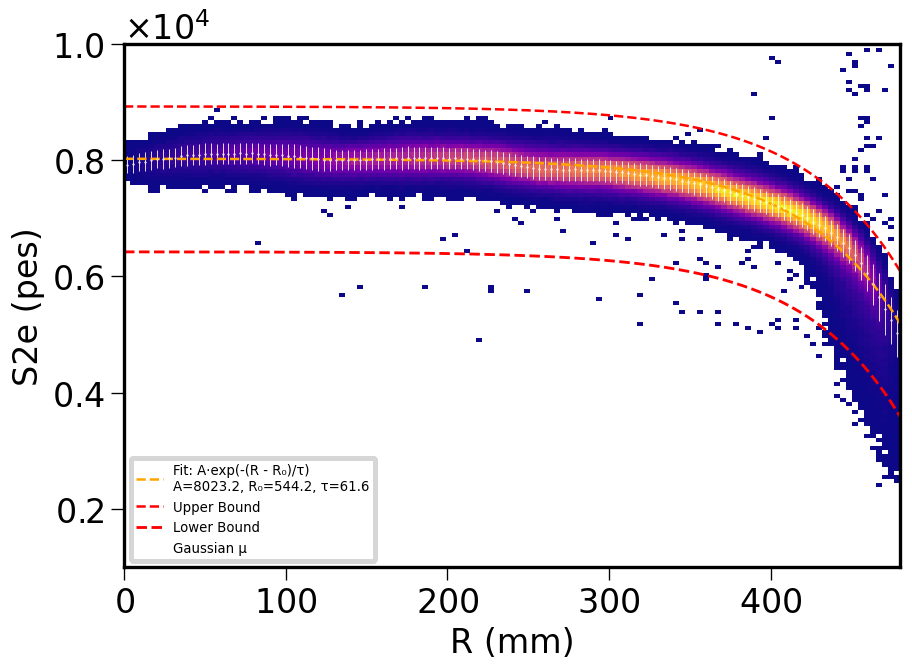

In [252]:
# Step 3: Fit with exponential model
def expo_model(R, A, R0, tau):
    return A *(1- np.exp((R - R0) / tau))

plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(df_testrun_single_s1_peak_geo['R'], df_testrun_single_s1_peak_geo['S2e'], bins=130, range=([0, 480], [1000, 10000]))
dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts2, xedges2, yedges2)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

p0=[8000, 600, 100]
popt, _ = curve_fit(expo_model, dt_centers, mean_vals, p0=p0)

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(dt_centers, mean_vals, yerr=sigma, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')

r_fit = np.linspace(0, 480, 500)
plt.plot(r_fit, expo_model(r_fit, *popt), color='orange', linestyle='--', linewidth=1.5, label=f'Fit: A·exp(-(R - R₀)/τ)\nA={popt[0]:.1f}, R₀={popt[1]:.1f}, τ={popt[2]:.1f}')
plt.plot(r_fit, expo_model(r_fit, *popt)+900, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound')
plt.plot(r_fit, expo_model(r_fit, *popt)-1600, color='red', linestyle='--', linewidth=1.7, label=f'Lower Bound')

plt.legend(fontsize=8)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [253]:
df_testrun_single_s1_peak_geo = df_testrun_single_s1_peak_geo[(df_testrun_single_s1_peak_geo['S2e'] >= expo_model(df_testrun_single_s1_peak_geo['R'], *popt) - 1600) & 
                             (df_testrun_single_s1_peak_geo['S2e'] <= expo_model(df_testrun_single_s1_peak_geo['R'], *popt) + 900)]

print(f"NEvent filtered road : {len(np.unique(Krdf['event']))}")
print(f"eff:{(len(np.unique(df_testrun_single_s1_peak_geo['event']))/len(np.unique(df_testrun['event'])))*100:.2f}%")

NEvent filtered road : 695001
eff:38.53%


In [254]:
krmap_loaded = af.load_kr_map("kr_maps/map_run15504_V2.npz")

In [255]:
Krdf_test = af.correct_S2e(df_testrun_single_s1_peak_geo, krmap_loaded, rmax=480.0, zmax=1350.0)

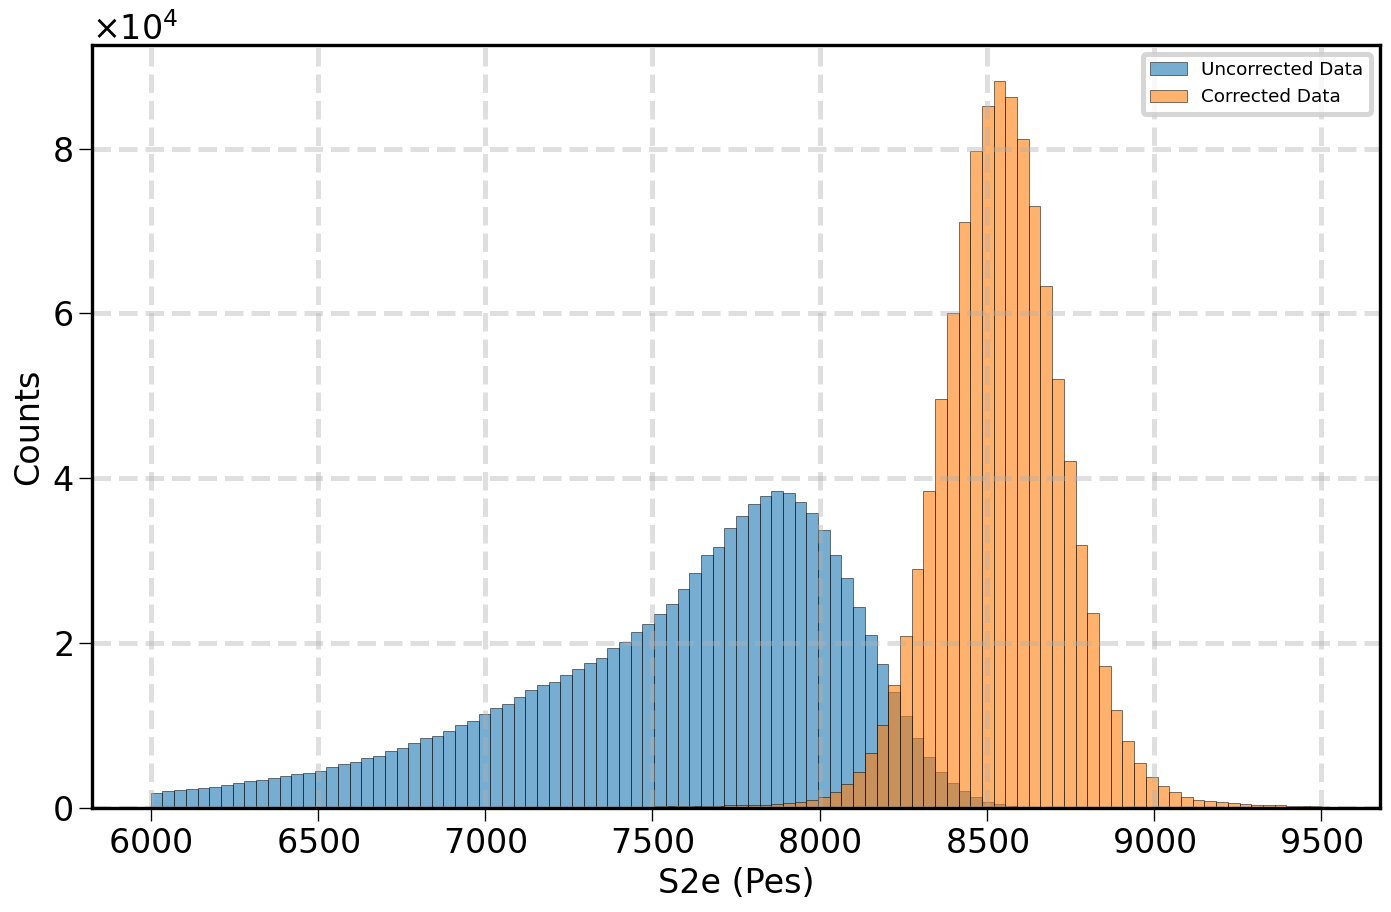

In [256]:
plt.figure(figsize=(12, 8), dpi=120)
# Plot S2e histogram
plt.hist(Krdf_test['S2e'], bins=100, range=(6000, 9500), alpha=0.6 , color='tab:blue', edgecolor='black', linewidth=0.5, label='Uncorrected Data')
# Plot Epes histogram
plt.hist(Krdf_test['Epes'], bins=100, range=(6000, 9500), alpha=0.6, color='tab:orange', edgecolor='black', linewidth=0.5, label='Corrected Data')

# Aesthetic settings
plt.xlabel('S2e (Pes)')
plt.ylabel('Counts')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

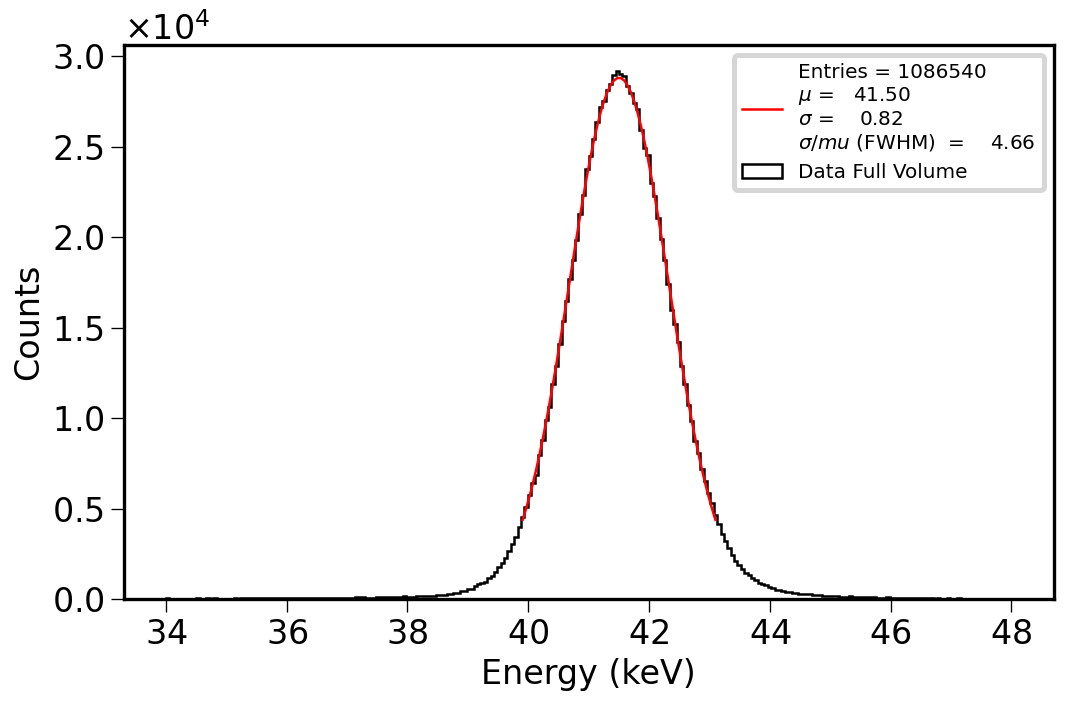

In [257]:
hp = af.HistoPar(var = Krdf_test['Epes']/Krdf_test['Epes'].mean()*41.5, nbins = 250, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 1.7)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data Full Volume")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

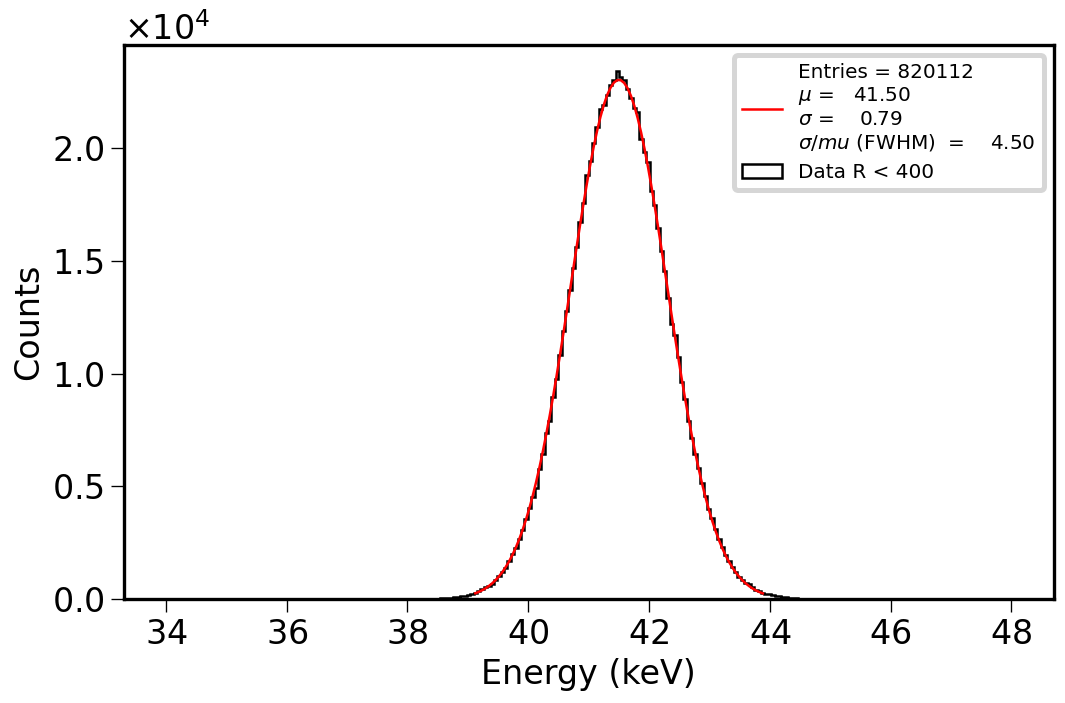

In [258]:
hp = af.HistoPar(var = Krdf_test[Krdf_test['R']<400]['Epes']/Krdf_test[Krdf_test['R']<400]['Epes'].mean()*41.5, nbins = 250, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 400")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

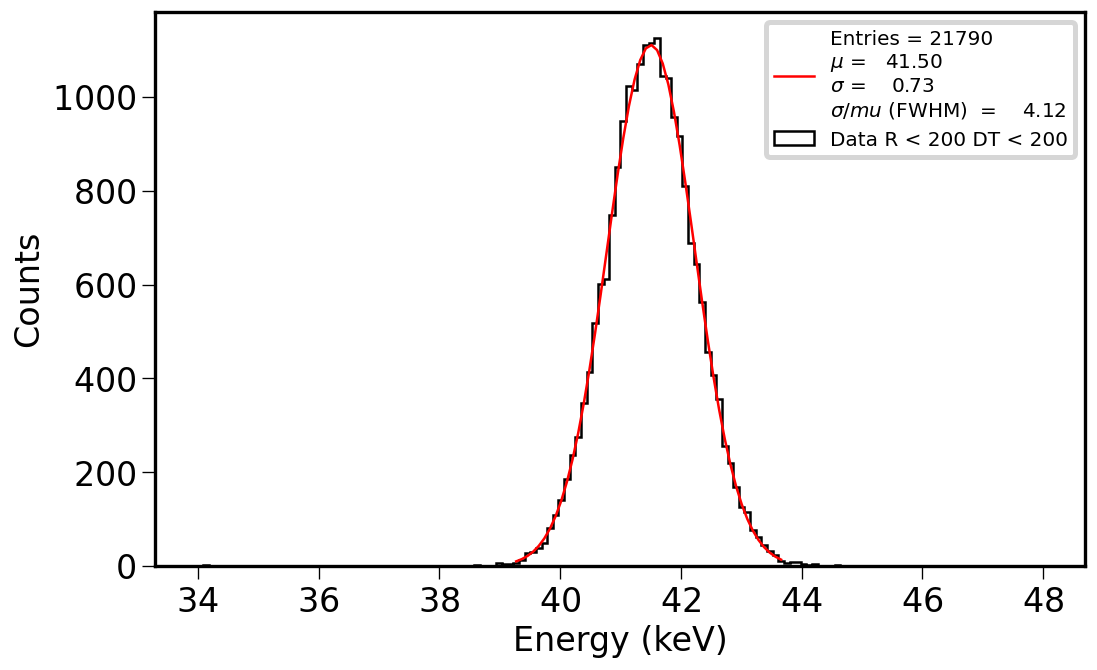

In [259]:
hp = af.HistoPar(var = Krdf_test[(Krdf_test['R']<200) & (Krdf_test['DT']<200)]['Epes']/Krdf_test[(Krdf_test['R']<200) & (Krdf_test['DT']<200)]['Epes'].mean()*41.5, nbins = 150, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 200 DT < 200")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')